In [1]:
import uproot
import glob
import pandas as pd
import warnings
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import yahist
import itertools
import mplhep as hep
import xgboost as xgb #BDT
import pickle

plt.rcParams.update({"figure.facecolor":  (1,1,1,0)})

from utils.analysis import Optimization

TAG = "abcdnet"

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
babies = sorted(glob.glob(f"../analysis/studies/vbsvvhjets/output_{TAG}/Run2/*.root"))
sig_babies = [baby for baby in babies if "VBS" in baby]
bkg_babies = [baby for baby in babies if "VBS" not in baby and "data" not in baby]
data_babies = [baby for baby in babies if "data" in baby]
print("Signal:")
print("\n".join(sig_babies))
print("Background:")
print("\n".join(bkg_babies))
print("Data:")
print("\n".join(data_babies))

Signal:
../analysis/studies/vbsvvhjets/output_abcdnet/Run2/VBSVVH.root
Background:
../analysis/studies/vbsvvhjets/output_abcdnet/Run2/Bosons.root
../analysis/studies/vbsvvhjets/output_abcdnet/Run2/QCD.root
../analysis/studies/vbsvvhjets/output_abcdnet/Run2/SingleTop.root
../analysis/studies/vbsvvhjets/output_abcdnet/Run2/TT1L.root
../analysis/studies/vbsvvhjets/output_abcdnet/Run2/TTH.root
../analysis/studies/vbsvvhjets/output_abcdnet/Run2/TTHad.root
../analysis/studies/vbsvvhjets/output_abcdnet/Run2/TTW.root
Data:
../analysis/studies/vbsvvhjets/output_abcdnet/Run2/data.root


In [3]:
vbsvvh = Optimization(
    sig_root_files=sig_babies,
    bkg_root_files=bkg_babies,
    data_root_files=data_babies,
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", 
        "pu_sf", 
        "prefire_sf", 
    ],
    plots_dir=f"/home/users/jguiang/public_html/vbsvvhjets_plots/{TAG}/opt",
    sample_labels = {
        "VBSVVH": r"VBS VVH $(C_{2V} = 2)$", 
        "TTHad": r"$t\bar{t}+$jets",
        "TT1L": r"$t\bar{t}+1\ell$",
        "QCD": "QCD",
        "SingleTop": r"Single $t$",
        "TTH": r"$t\bar{t}+H$",
        "TTW": r"$t\bar{t}+W$",
    },
#     reweight_column="reweights"
)

vbsvvh.df["obj_sel"] = True
# vbsvvh.df["qcdnorm_CR"] = vbsvvh.df.eval(
#     "obj_sel and hbbfatjet_xbb > 0.1 and ld_vqqfatjet_xwqq > 0.5 and tr_vqqfatjet_xwqq > 0.5"
# )
# vbsvvh.make_selection("qcdnorm_CR")

bkg_count = vbsvvh.bkg_count()
qcd_count = vbsvvh.sample_count("QCD")
data_count = vbsvvh.data_count()

vbsvvh.df.loc[vbsvvh.df.name == "QCD", "event_weight"] *= (data_count - (bkg_count - qcd_count))/(qcd_count)

Loading data babies: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/abcdnet_score_sig_vs_bkg_stacked_logy_obj_sel.pdf


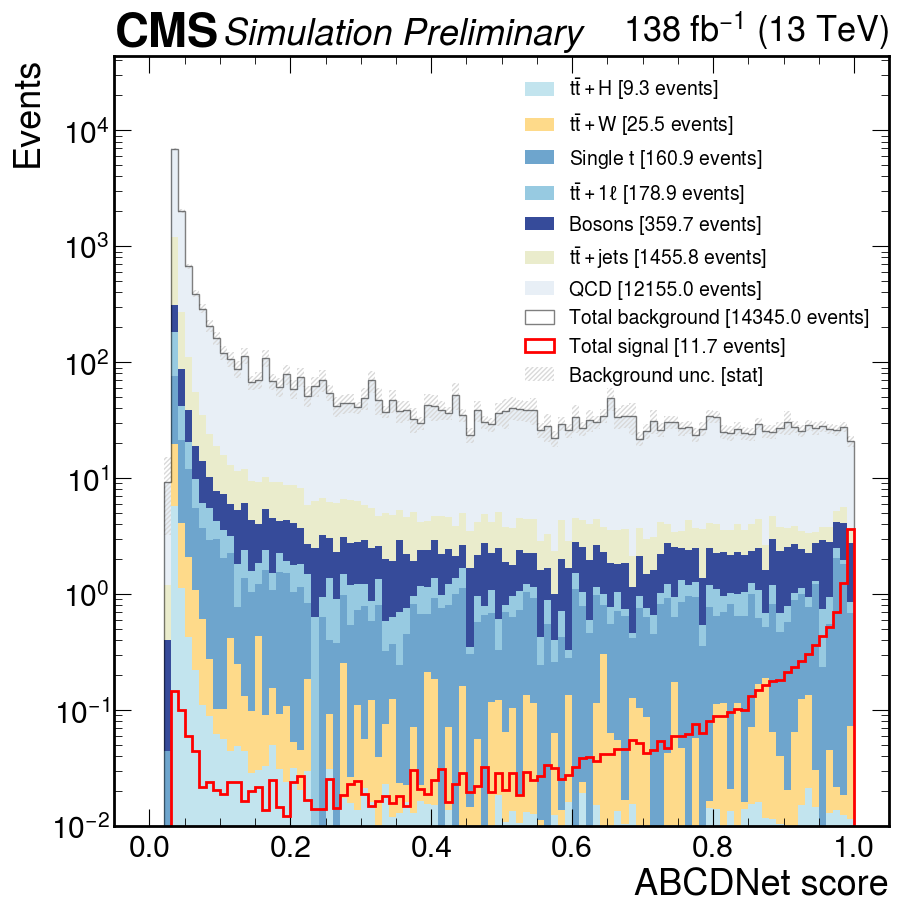

In [4]:
axes = vbsvvh.plot_sig_vs_bkg(
    "abcdnet_score", np.linspace(0, 1, 101), 
    selection="obj_sel",
    x_label="ABCDNet score",
    stacked=True,
    sig_scale=1,
    logy=True,
#     norm=True
);

In [ ]:
axes = vbsvvh.plot_sig_vs_bkg(
    "abcdnet_score1", np.linspace(0, 1, 101), 
    selection="obj_sel",
    x_label="ABCDNet f-score",
    stacked=True,
    sig_scale=1,
    logy=True,
#     norm=True
);

In [ ]:
axes = vbsvvh.plot_sig_vs_bkg(
    "abcdnet_score2", np.linspace(0, 1, 101), 
    selection="obj_sel",
    x_label="ABCDNet g-score",
    stacked=True,
    sig_scale=1,
    logy=True,
#     norm=True
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/abcdnet_score1_correlations_name_neq_''.pdf


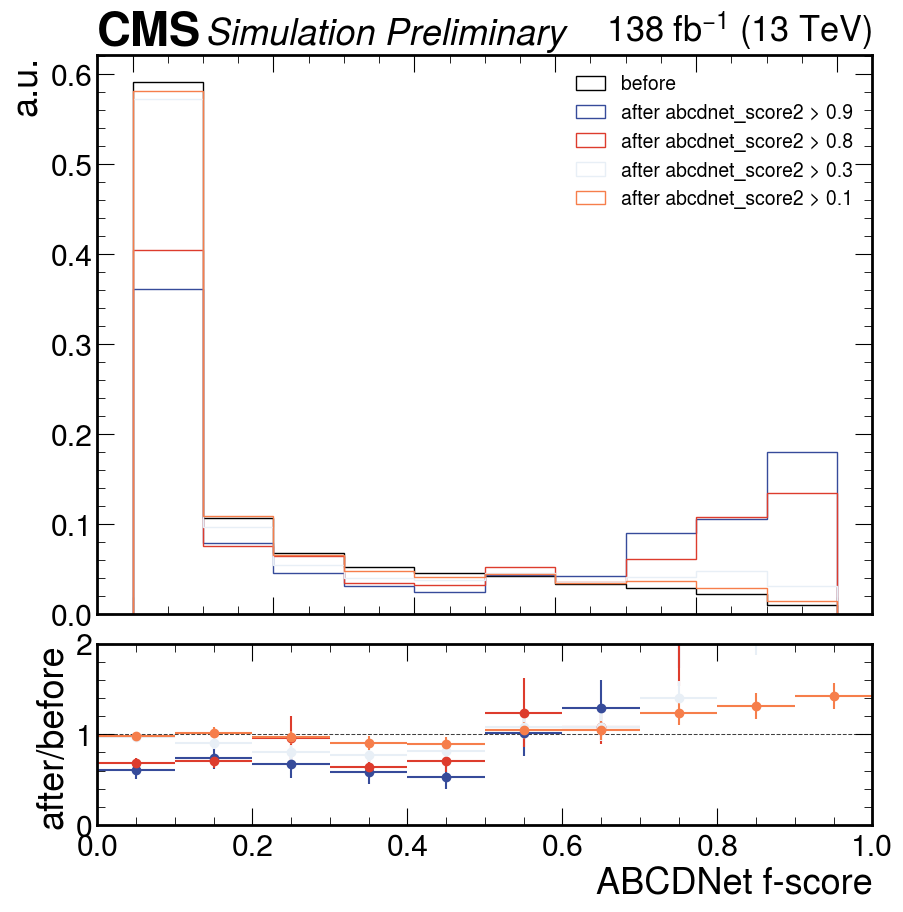

In [14]:
vbsvvh.plot_correlation(
    "abcdnet_score1", 
    np.linspace(0, 1, 11),  
    selections=[
        "abcdnet_score2 > 0.9",
        "abcdnet_score2 > 0.8",
        "abcdnet_score2 > 0.3",
        "abcdnet_score2 > 0.1",        
        
    ], 
    x_label=r"ABCDNet f-score"
);

<AxesSubplot:>

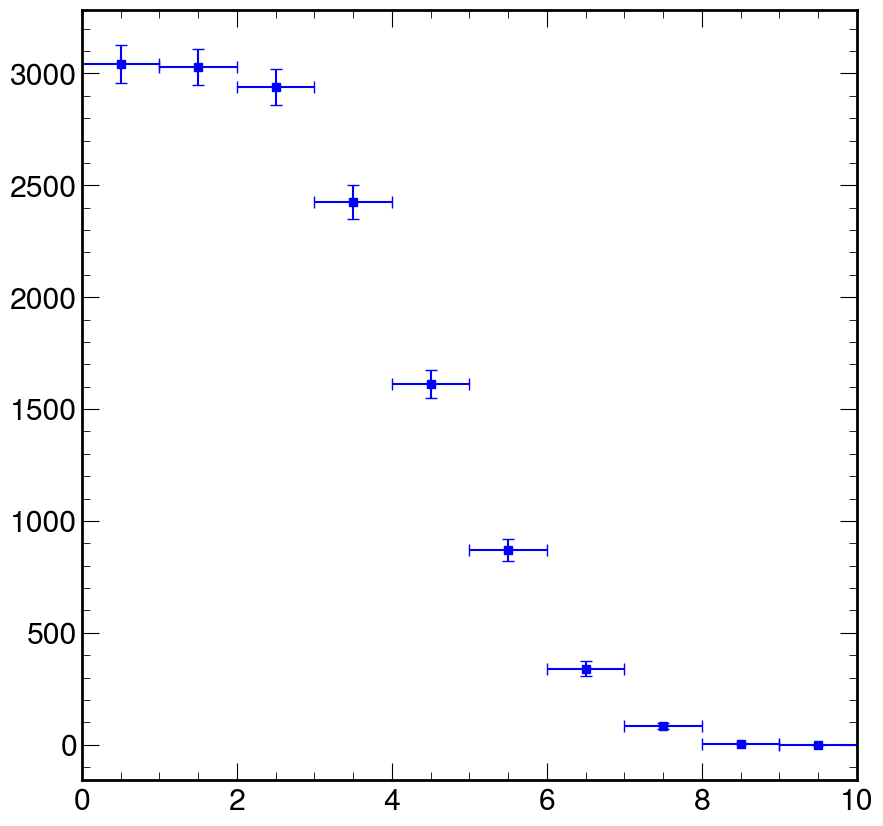

In [9]:
h = yahist.Hist1D(
    vbsvvh.bkg_df().abs_deta_jj,
    bins=np.linspace(0, 10, 11),
    weights=vbsvvh.bkg_df().event_weight,
    color="b"
);

h.plot(errors=True, fmt="s", capsize=4)

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/abs_deta_jj_correlations_obj_sel.pdf


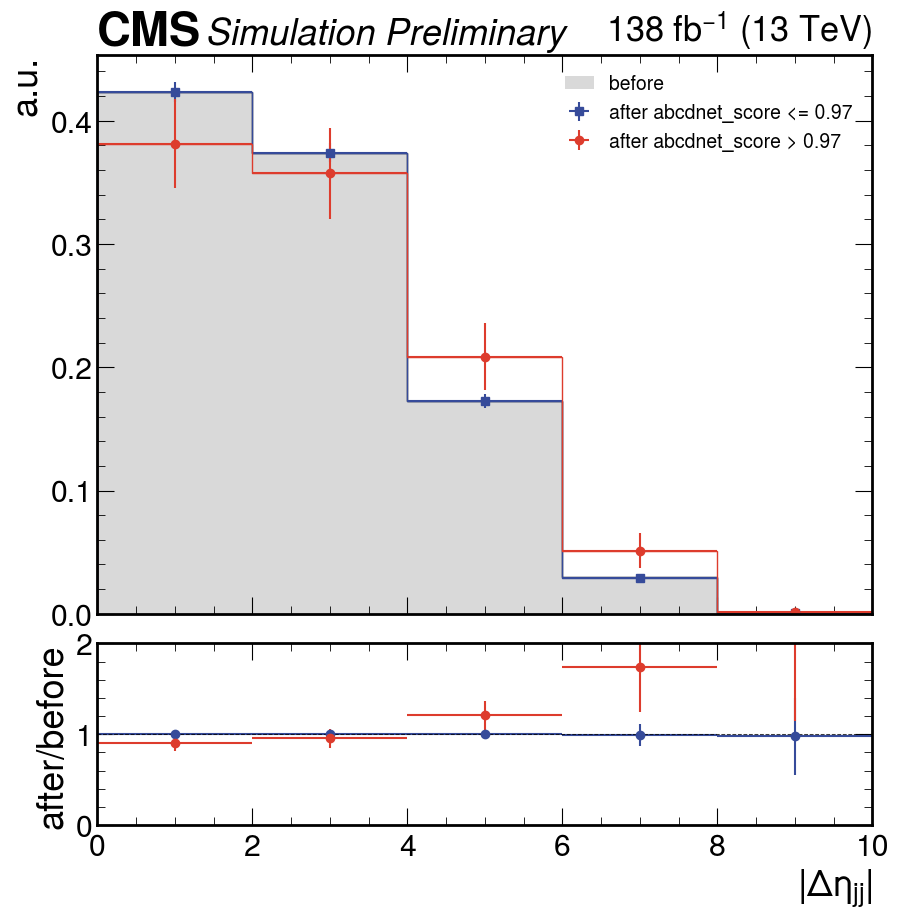

In [11]:
vbsvvh.plot_correlation(
    "abs_deta_jj", 
    np.linspace(0, 10, 6),  
    selections=[
        "abcdnet_score <= 0.97",
        "abcdnet_score > 0.97",
    ], 
    base_selection="obj_sel",
    x_label=r"$|\Delta\eta_{jj}|$"
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/abs_deta_jj_correlations_hbbfatjet_xbb_gt_0p60_and_ld_vqqfatjet_xwqq_gt_0p75_and_tr_vqqfatjet_xwqq_gt_0p70.pdf


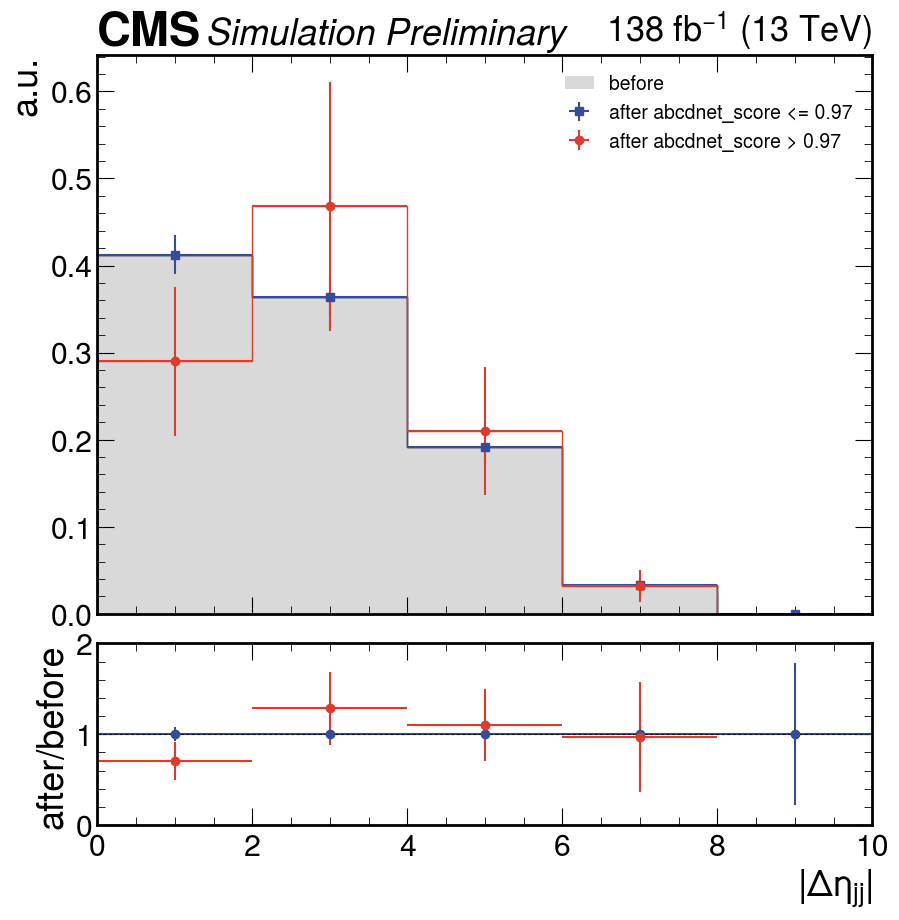

In [8]:
vbsvvh.plot_correlation(
    "abs_deta_jj", 
    np.linspace(0, 10, 6),  
    selections=[
        "abcdnet_score <= 0.97",
        "abcdnet_score > 0.97",
    ], 
    base_selection="hbbfatjet_xbb > 0.60 and ld_vqqfatjet_xwqq > 0.75 and tr_vqqfatjet_xwqq > 0.70",
    x_label=r"$|\Delta\eta_{jj}|$"
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/abs_deta_jj_correlations_name_neq_''.pdf


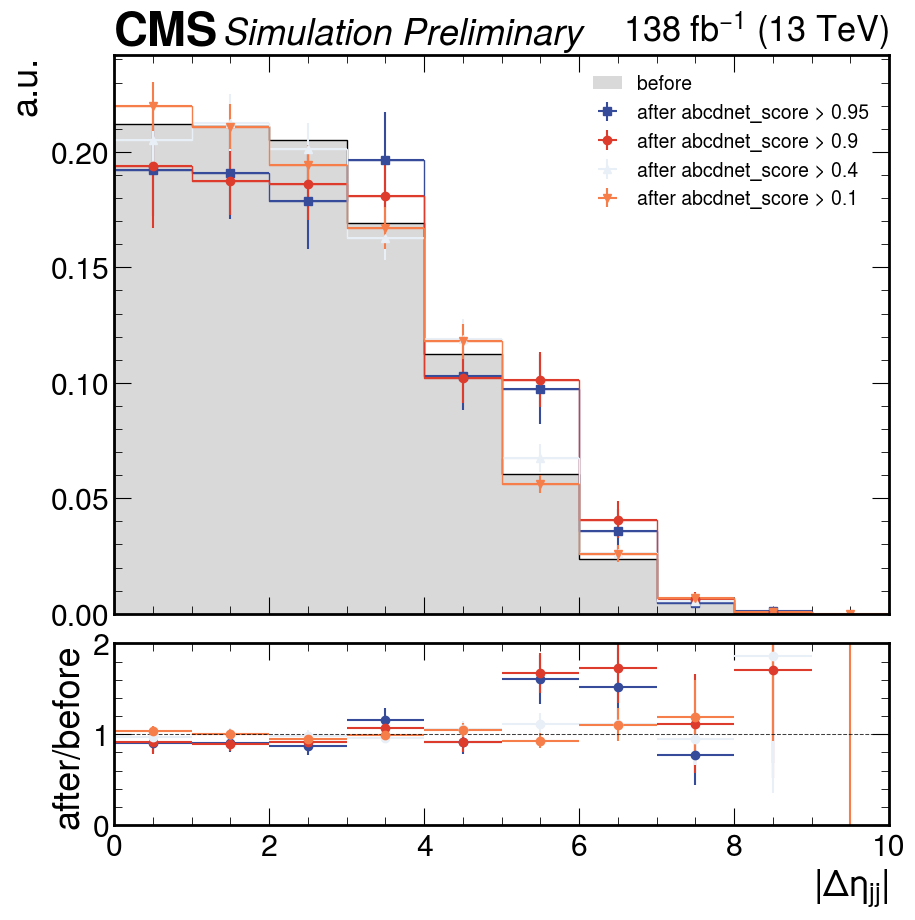

In [4]:
vbsvvh.plot_correlation(
    "abs_deta_jj", 
    np.linspace(0, 10, 11),  
    selections=[
        "abcdnet_score > 0.95",
        "abcdnet_score > 0.9",
        "abcdnet_score > 0.4",
#         "abcdnet_score > 0.7",
#         "abcdnet_score > 0.5",
        "abcdnet_score > 0.1",        
        
    ], 
    x_label=r"$|\Delta\eta_{jj}|$"
);

# vbsvvh.plot_sig_vs_bkg(
#     "abs_deta_jj", np.linspace(0, 10, 6), 
#     x_label=r"$|\Delta\eta_{jj}|$",
#     stacked=True,
#     norm=True
# )

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/abs_deta_jj_correlations_name_neq_''.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/abs_deta_jj_sig_vs_bkg_stacked_norm.pdf


<AxesSubplot:xlabel='$|\\Delta\\eta_{jj}|$', ylabel='a.u.'>

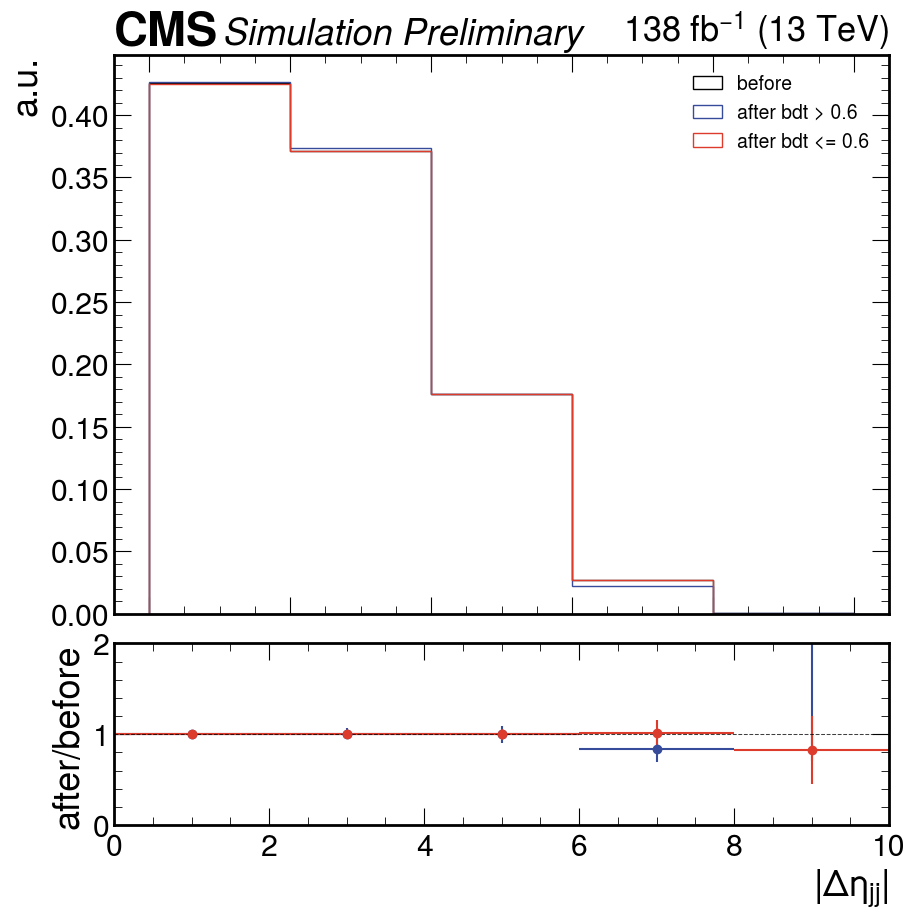

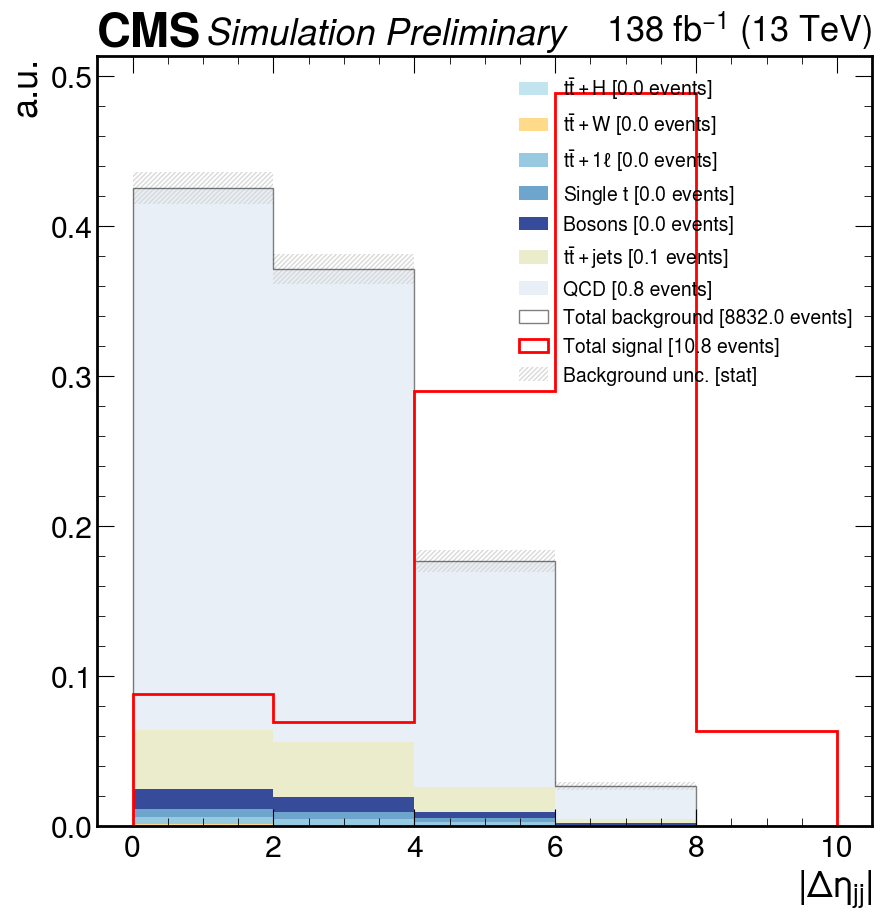

In [17]:
vbsvvh.plot_correlation(
    "abs_deta_jj", 
    np.linspace(0, 10, 6),  
    selections=[
        "bdt > 0.6",
        "bdt <= 0.6"
    ], 
    x_label=r"$|\Delta\eta_{jj}|$"
);

vbsvvh.plot_sig_vs_bkg(
    "abs_deta_jj", np.linspace(0, 10, 6), 
    x_label=r"$|\Delta\eta_{jj}|$",
    stacked=True,
    norm=True
)

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/deta_jj_correlations_SR_like.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/deta_jj_correlations_SR_like_noXbb.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/deta_jj_sig_vs_bkg_stacked_norm_SR_like_and_bdt_gt_0p6.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/deta_jj_sig_vs_bkg_stacked_norm_SR_like_and_bdt_leq_0p6.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/deta_jj_sig_vs_bkg_stacked_norm_SR_like_noXbb_and_bdt_gt_0p6.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/deta_jj_sig_vs_bkg_stacked_norm_SR_like_noXbb_and_bdt_leq_0p6.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/deta_jj_sig_vs_bkg_stacked_norm_SR_like_noXbb_and_bdt_gt_0p6.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/abcdnet/opt/deta_jj_sig_v

<AxesSubplot:xlabel='$|\\Delta\\eta_{jj}|$', ylabel='Events'>

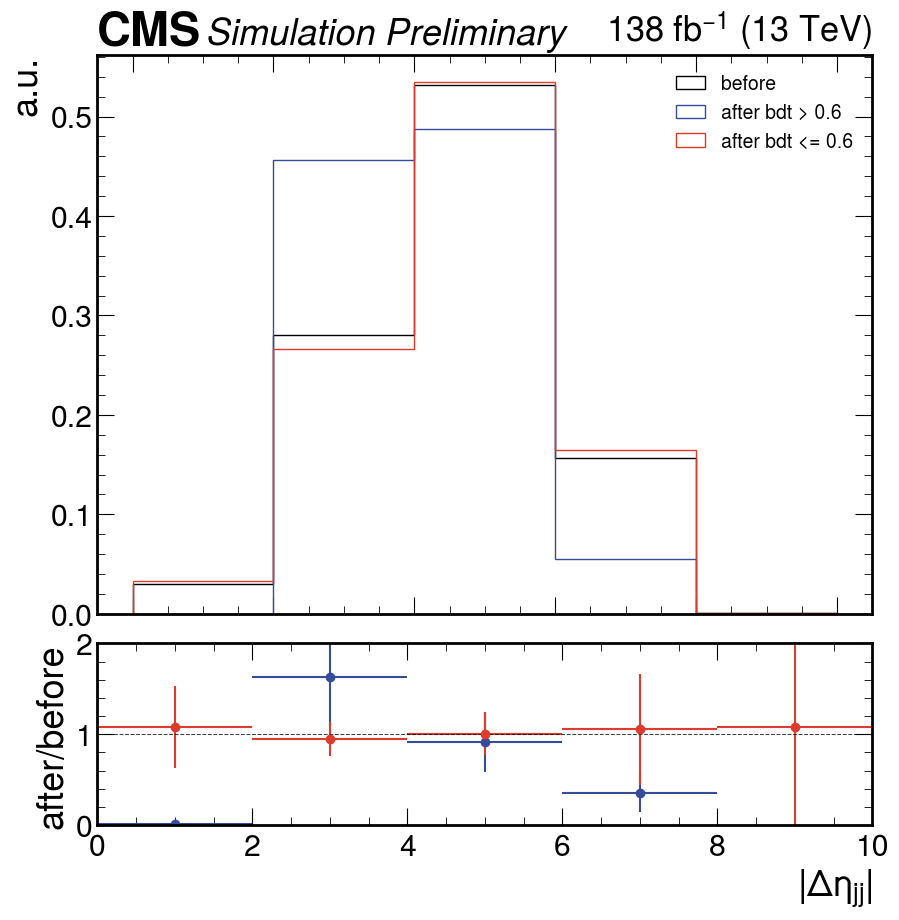

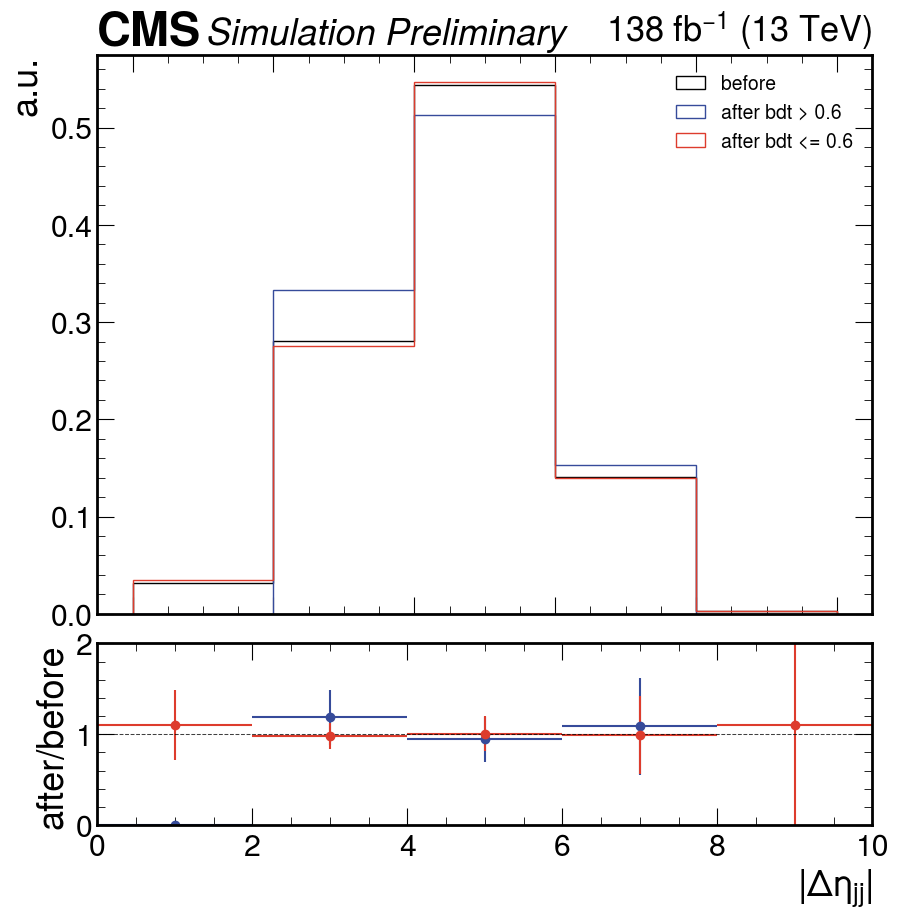

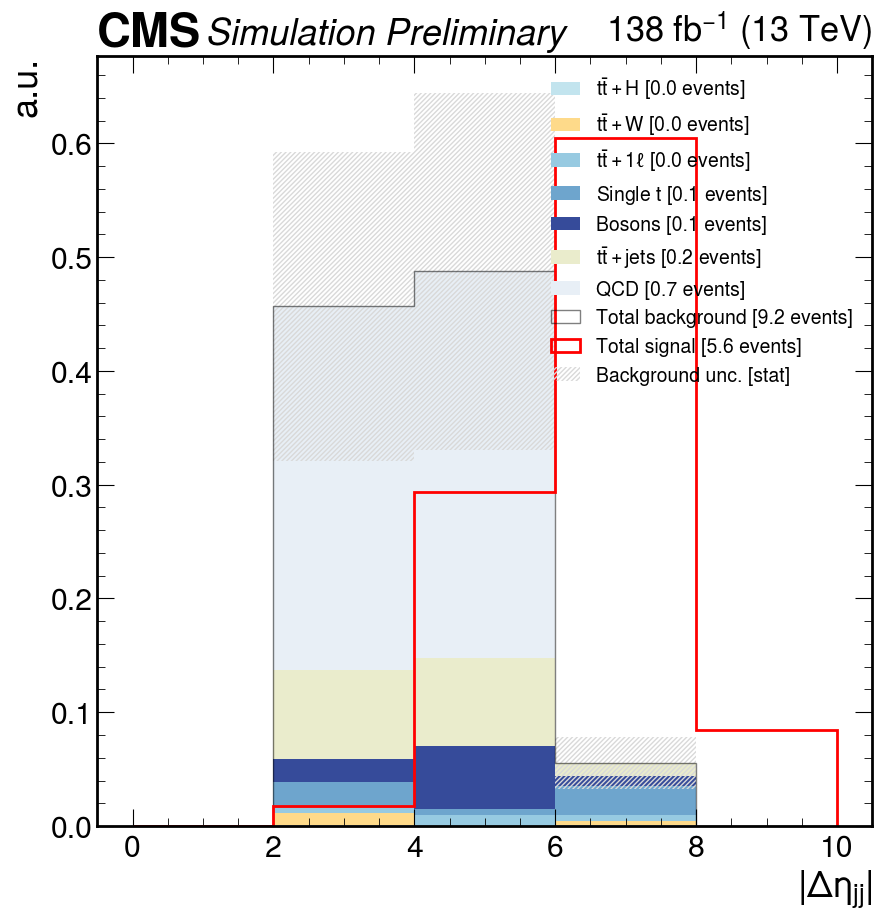

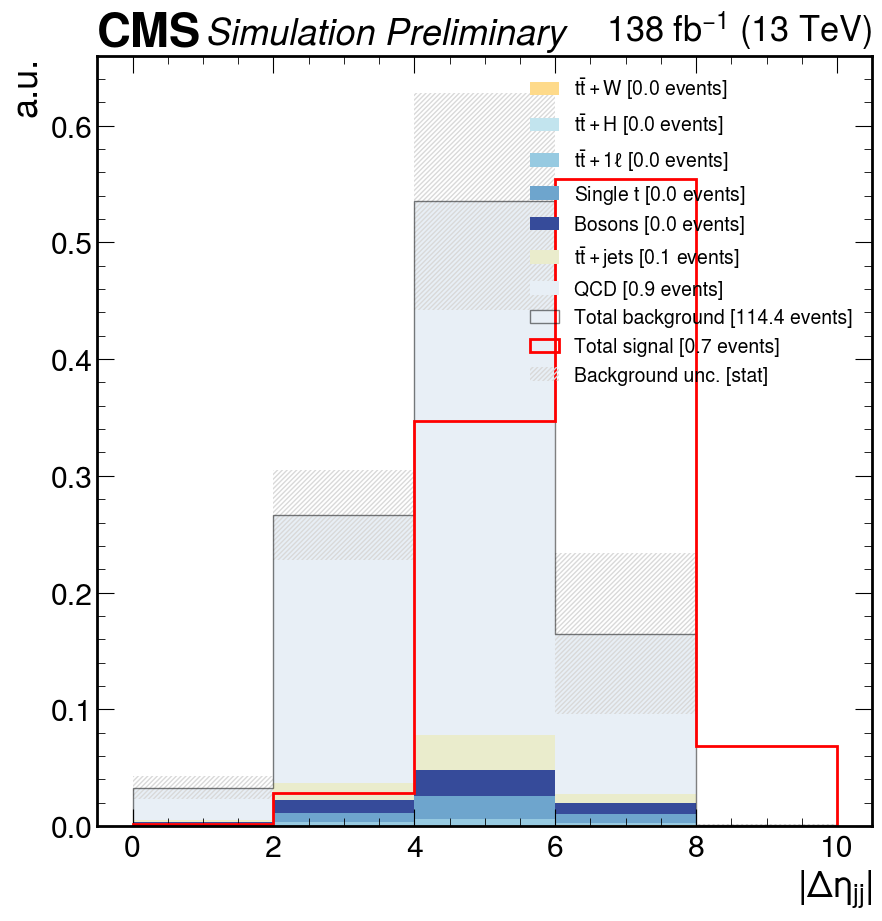

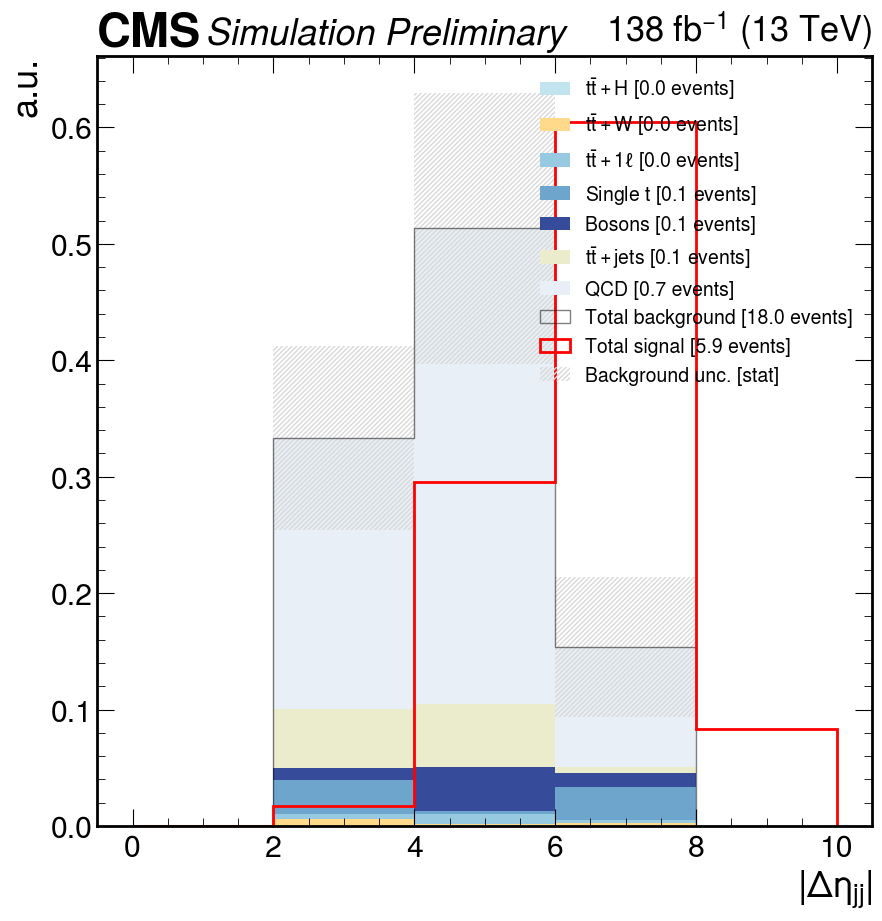

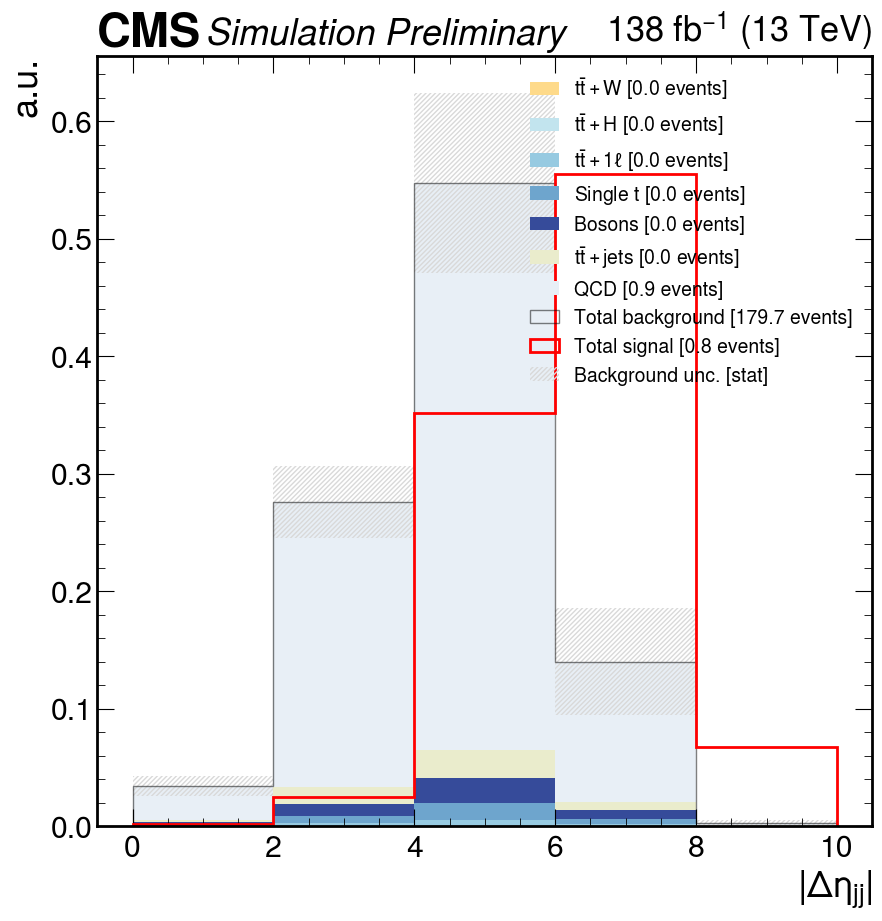

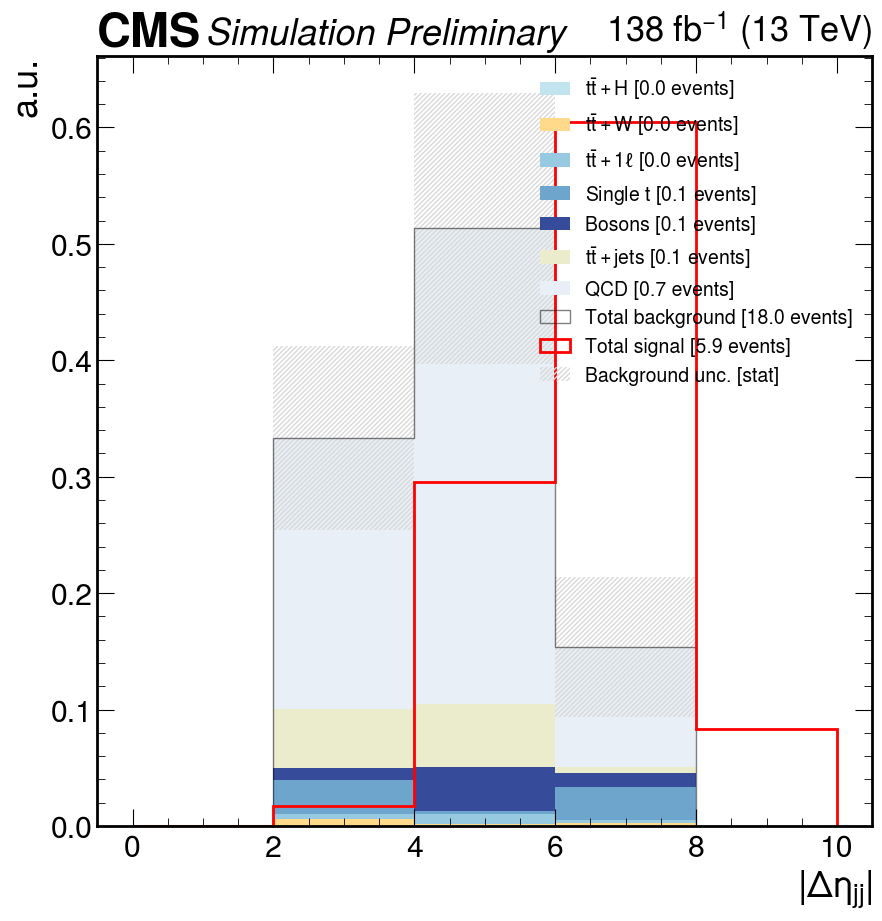

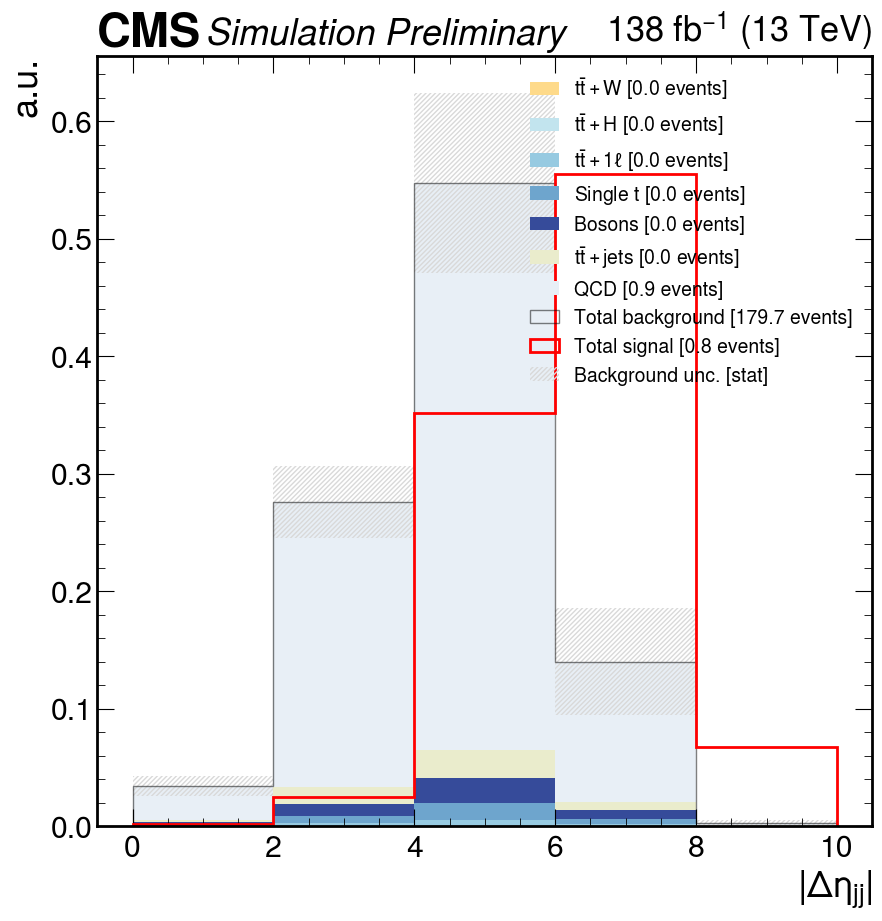

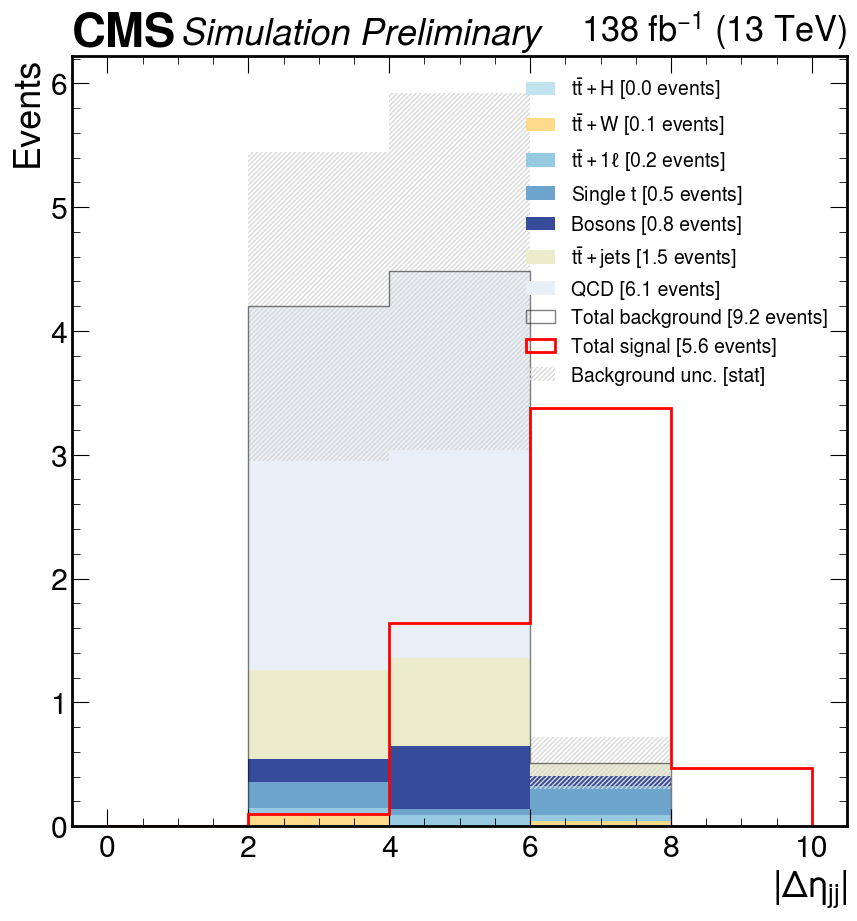

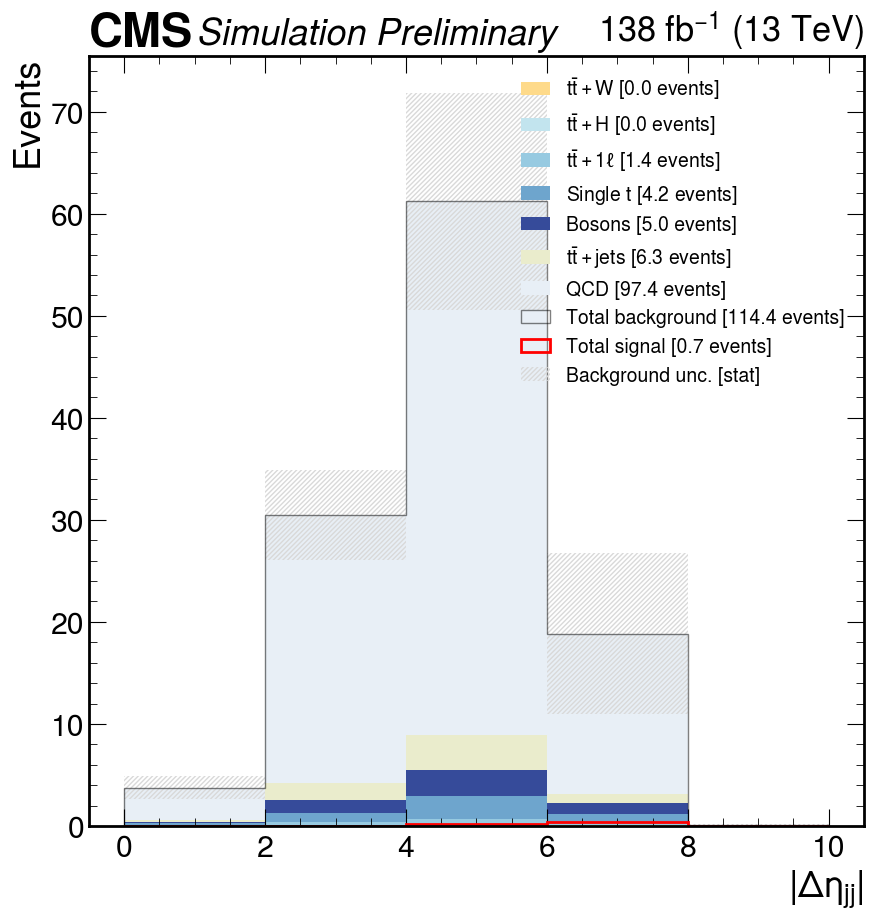

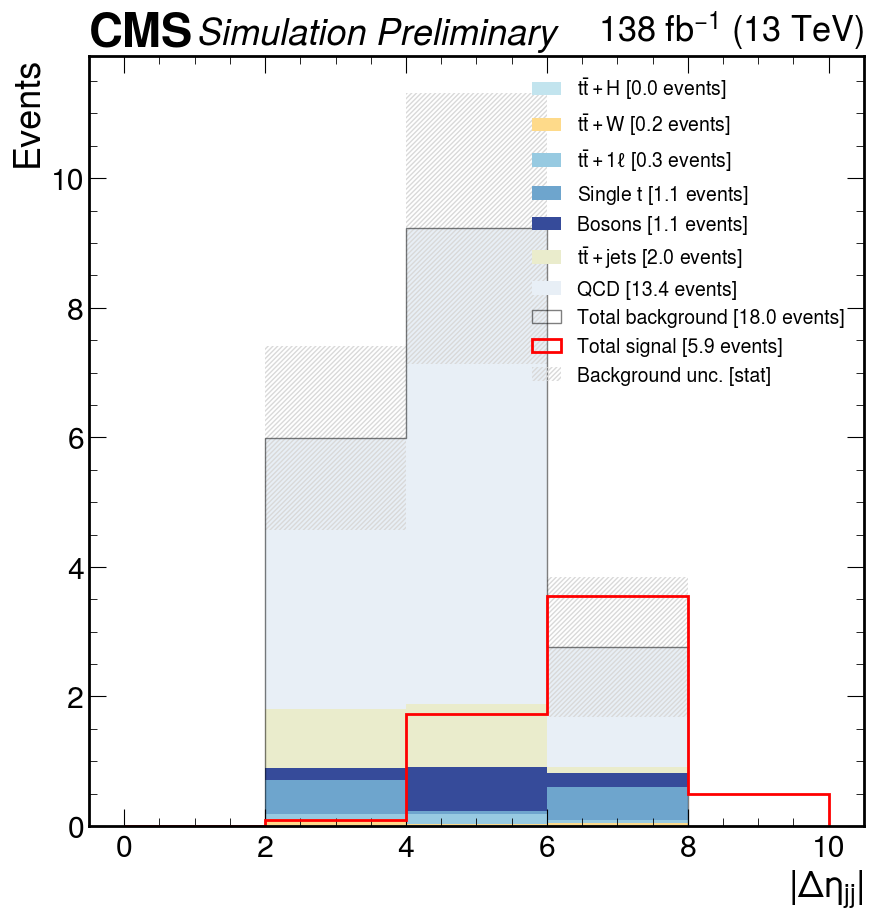

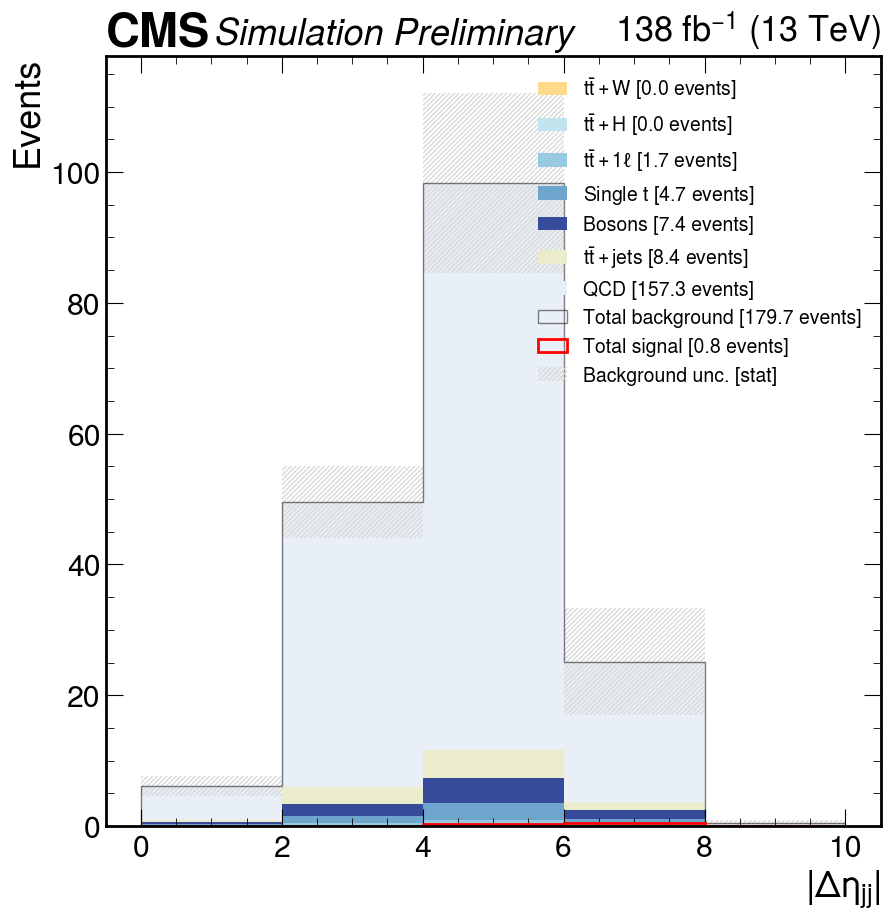

In [18]:
vbsvvh.df["SR_like"] = vbsvvh.df.eval(
    "obj_sel and qcdnorm_CR"
    + " and hbbfatjet_xbb > 0.6"
    + " and ld_vqqfatjet_xwqq > 0.6"
    + " and tr_vqqfatjet_xwqq > 0.65"
    + " and ST > 1300"
    + " and hbbfatjet_mass < 150"
    + " and ld_vqqfatjet_mass < 120 and tr_vqqfatjet_mass < 120"
    + " and M_jj > 600"
)

vbsvvh.df["SR_like_noXbb"] = vbsvvh.df.eval(
    "obj_sel and qcdnorm_CR"
#     + " and hbbfatjet_xbb > 0.6"
    + " and ld_vqqfatjet_xwqq > 0.6"
    + " and tr_vqqfatjet_xwqq > 0.65"
    + " and ST > 1300"
    + " and hbbfatjet_mass < 150"
    + " and ld_vqqfatjet_mass < 120 and tr_vqqfatjet_mass < 120"
    + " and M_jj > 600"
)

vbsvvh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 6),  
    selections=[
        "bdt > 0.6",
        "bdt <= 0.6"
    ], 
    base_selection="SR_like",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

vbsvvh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 6),  
    selections=[
        "bdt > 0.6",
        "bdt <= 0.6"
    ], 
    base_selection="SR_like_noXbb",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);


vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 6), 
    selection=f"SR_like and bdt > 0.6",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
    stacked=True,
    norm=True
)
vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 6), 
    selection=f"SR_like and bdt <= 0.6",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
    stacked=True,
    norm=True
)
vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 6), 
    selection=f"SR_like_noXbb and bdt > 0.6",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
    stacked=True,
    norm=True
)
vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 6), 
    selection=f"SR_like_noXbb and bdt <= 0.6",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
    stacked=True,
    norm=True
)


vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 6), 
    selection=f"SR_like_noXbb and bdt > 0.6",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
    stacked=True,
    norm=True
)
vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 6), 
    selection=f"SR_like_noXbb and bdt <= 0.6",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
    stacked=True,
    norm=True
)


vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 6), 
    selection=f"SR_like and bdt > 0.6",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
    stacked=True,
    norm=False
)
vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 6), 
    selection=f"SR_like and bdt <= 0.6",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
    stacked=True,
    norm=False
)
vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 6), 
    selection=f"SR_like_noXbb and bdt > 0.6",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
    stacked=True,
    norm=False
)
vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 6), 
    selection=f"SR_like_noXbb and bdt <= 0.6",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$",
    stacked=True,
    norm=False
)

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/pnetfix/opt/ST_correlations_SR_like.pdf


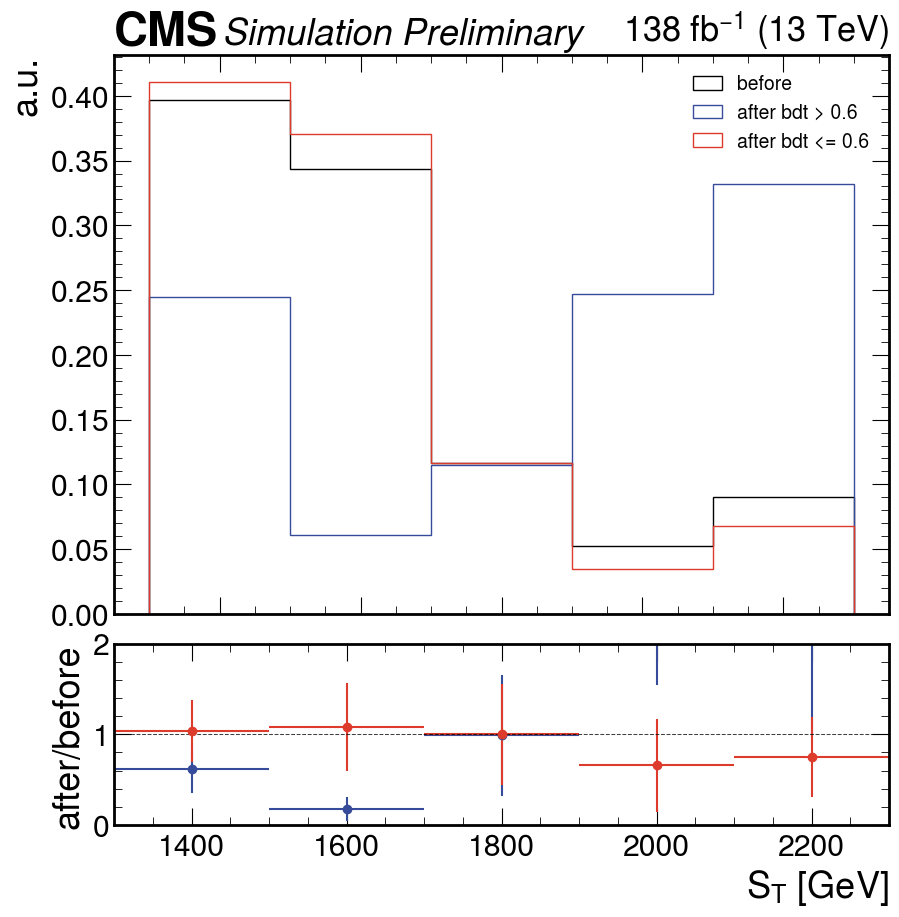

In [6]:
vbsvvh.plot_correlation(
    "ST", 
    np.linspace(1300, 2300, 6),  
    selections=[
        "bdt > 0.6",
        "bdt <= 0.6"
    ], 
    base_selection="SR_like",
    x_label=r"$S_T$ [GeV]"
);

In [8]:
vbsvvh.get_event_counts(selection="SR_like")

(5.287695265268502, 23.28207668349735)

In [18]:
vbsvvh.get_event_counts(selection="SR_like and bdt > 0.6 and abs_deta_jj > 4 and M_jj > 700")

(4.510855266105606, 0.658333711278037)

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/pnetfix/opt/bdt_correlations_hbbfatjet_xbb_gt_0p9_and_ld_vqqfatjet_xwqq_gt_0p65_and_tr_vqqfatjet_xwqq_gt_0p7_and_ST_gt_1300_and_hbbfatjet_mass_lt_150_and_ld_vqqfatjet_mass_lt_120_and_tr_vqqfatjet_mass_lt_120_and_M_jj_gt_500_and_abs_deta_jj_gt_3.pdf


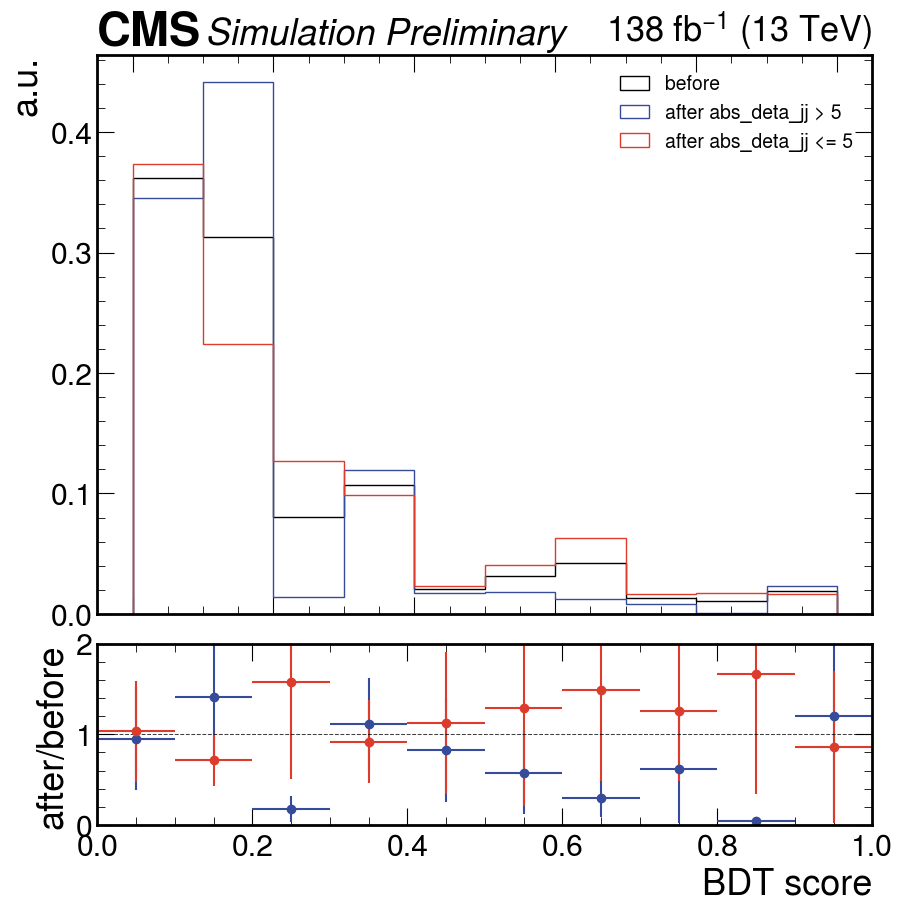

In [12]:
SR_like = (
    "hbbfatjet_xbb > 0.9 and ld_vqqfatjet_xwqq > 0.65 and tr_vqqfatjet_xwqq > 0.7"
    + " and ST > 1300"
    + " and hbbfatjet_mass < 150"
    + " and ld_vqqfatjet_mass < 120 and tr_vqqfatjet_mass < 120"
    + " and M_jj > 500 and abs_deta_jj > 3"
)

vbsvvh.plot_correlation(
    "bdt", 
    np.linspace(0, 1, 11),  
    selections=[
        "abs_deta_jj > 5",
        "abs_deta_jj <= 5"
    ], 
    base_selection=SR_like,
    x_label="BDT score"
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/pnetfix/opt/deta_jj_correlations_SR_like.pdf


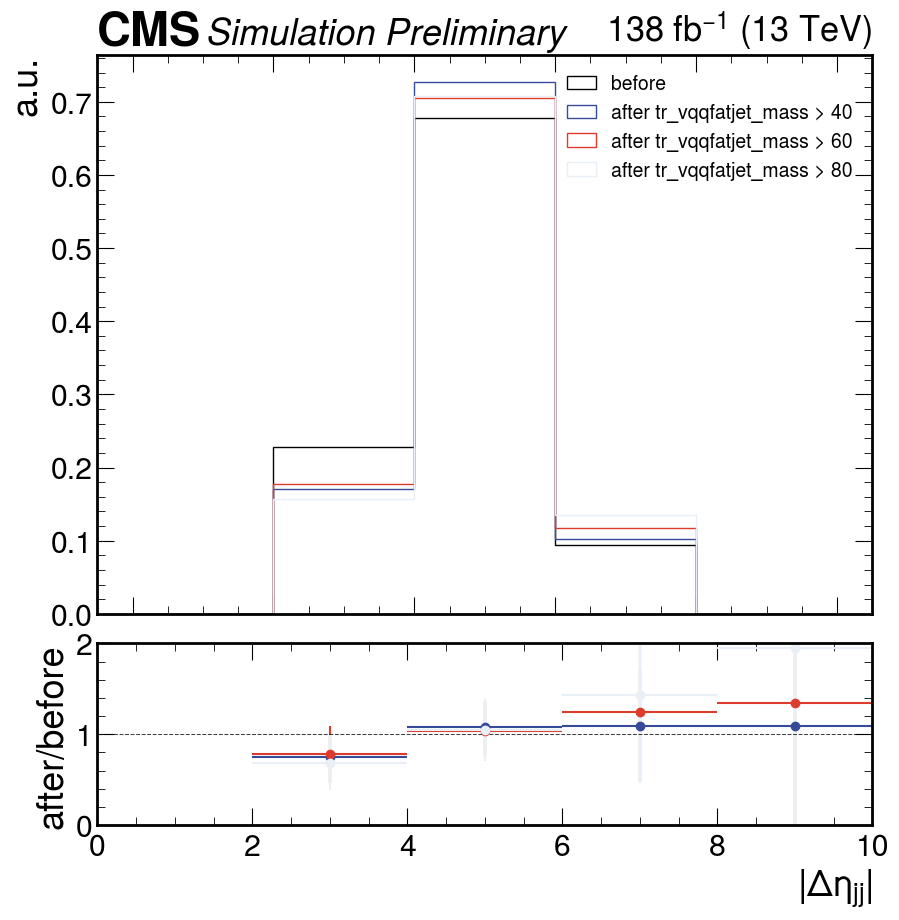

In [22]:
vbsvvh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 6),  
    selections=[
        "tr_vqqfatjet_mass > 40",
        "tr_vqqfatjet_mass > 60",
        "tr_vqqfatjet_mass > 80"
    ], 
    base_selection="SR_like",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/pnetfix/opt/deta_jj_correlations_SR_like.pdf


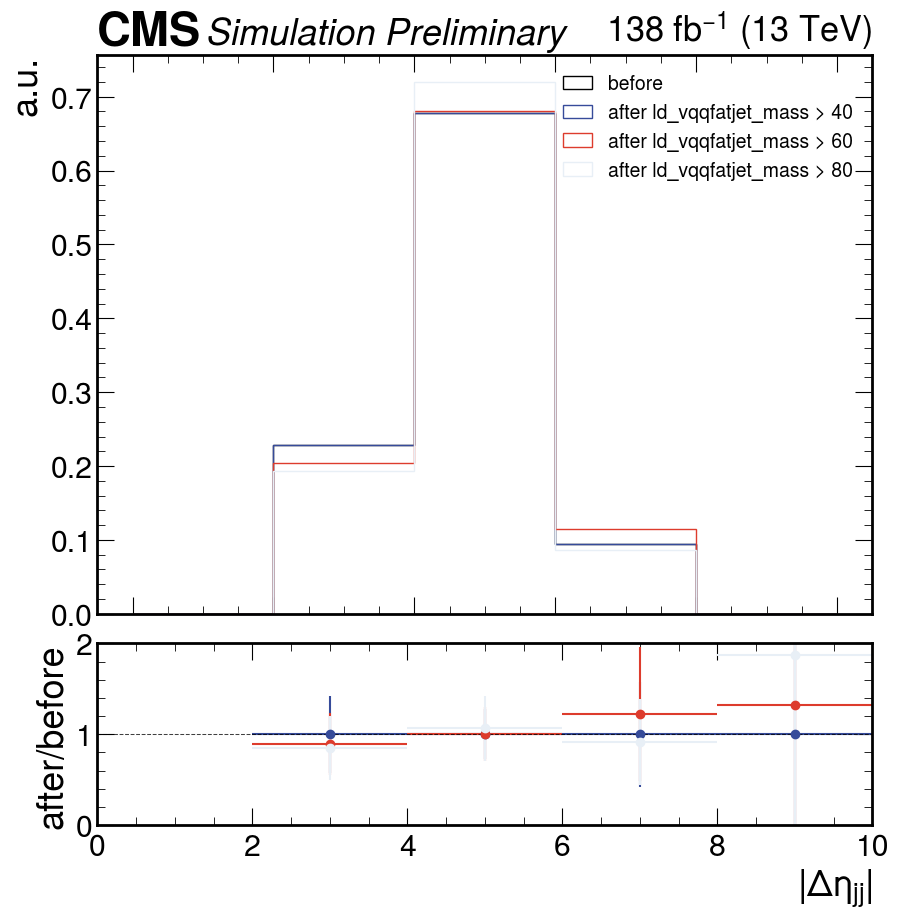

In [21]:
vbsvvh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 6),  
    selections=[
        "ld_vqqfatjet_mass > 40",
        "ld_vqqfatjet_mass > 60",
        "ld_vqqfatjet_mass > 80"
    ], 
    base_selection="SR_like",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/pnetfix/opt/deta_jj_correlations_SR_like.pdf


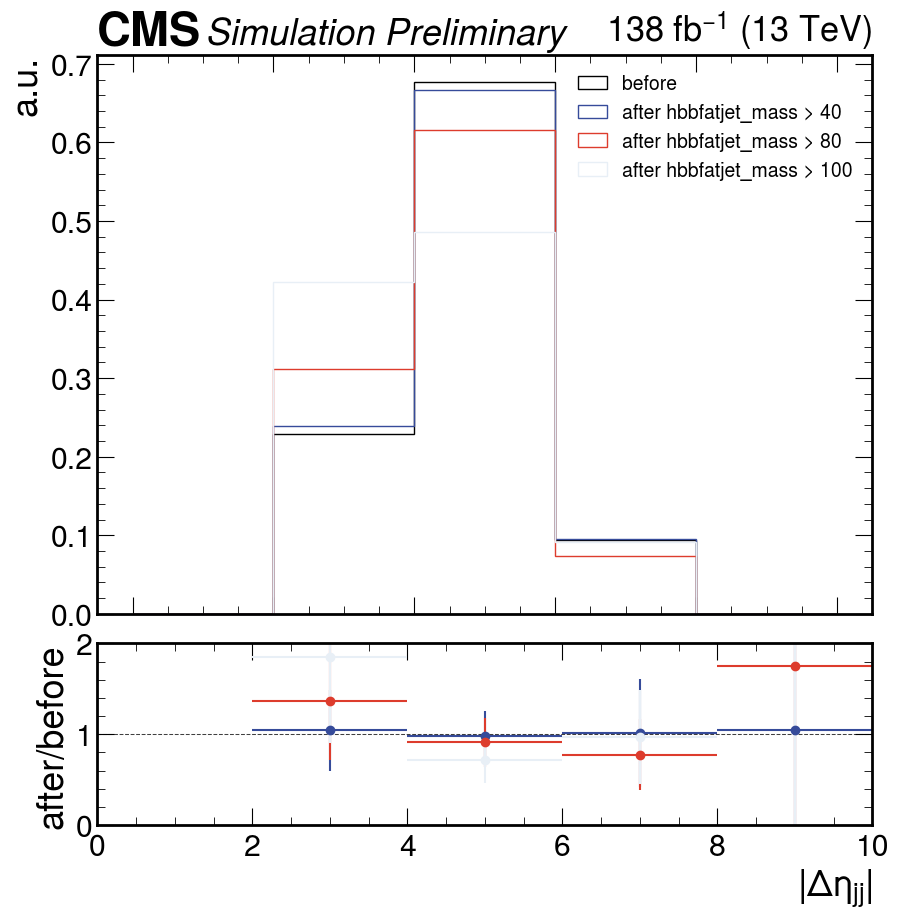

In [28]:
vbsvvh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 6),  
    selections=[
        "hbbfatjet_mass > 40",
        "hbbfatjet_mass > 80",
        "hbbfatjet_mass > 100"
    ], 
    base_selection="SR_like",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/pnetfix/opt/deta_jj_correlations_SR_like.pdf


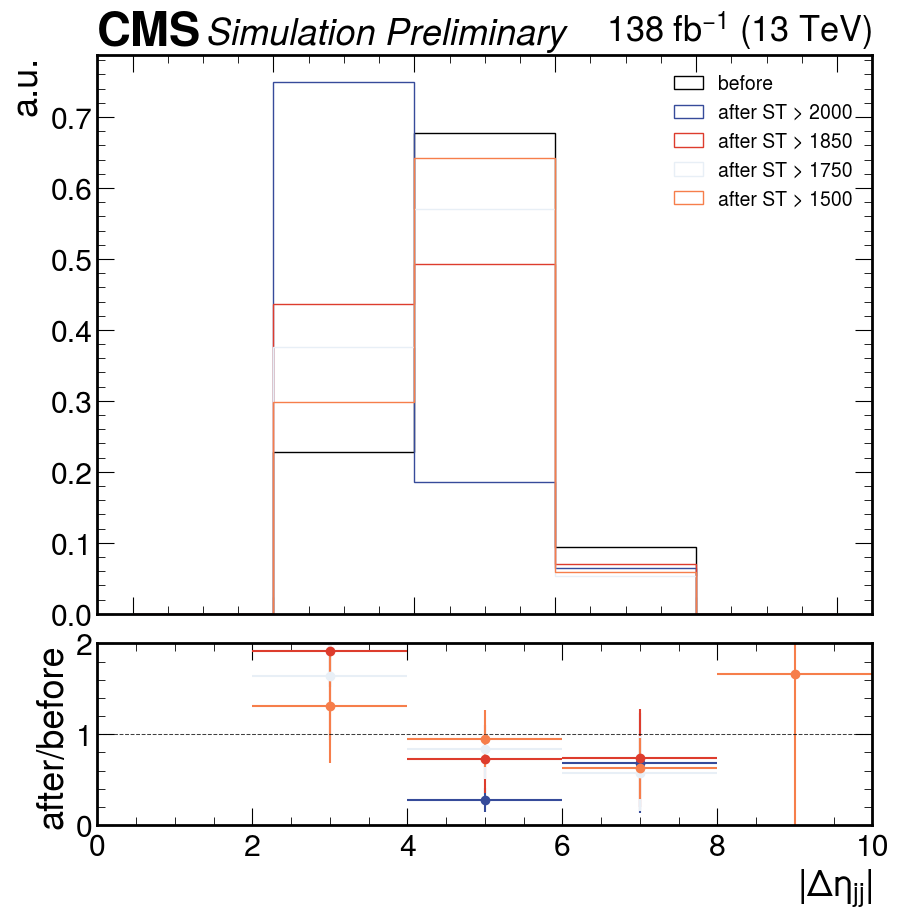

In [19]:
vbsvvh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 6),  
    selections=[
        "ST > 2000",
        "ST > 1850",
        "ST > 1750",
        "ST > 1500"
    ], 
    base_selection="SR_like",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

In [4]:
vbsvvh.df["obj_sel"] = True
vbsvvh.df["bdt_presel"] = vbsvvh.df.eval(
    "ST > 1300"
    + " and hbbfatjet_score > 0.5"
    + " and ld_vqqfatjet_score > 0.5 and tr_vqqfatjet_score > 0.5"
    + " and ld_vqqfatjet_mass < 120 and tr_vqqfatjet_mass < 120"
    + " and hbbfatjet_mass < 150"
)
vbsvvh.df["in_narrow_hwindow"] = vbsvvh.df.eval("hbbfatjet_mass >= 110 and hbbfatjet_mass < 140")

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/ST_sig_vs_bkg_stacked_bdt_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/M_jj_sig_vs_bkg_stacked_bdt_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/deta_jj_sig_vs_bkg_stacked_bdt_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/hbbfatjet_mass_sig_vs_bkg_stacked_bdt_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/ld_vqqfatjet_mass_sig_vs_bkg_stacked_bdt_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/tr_vqqfatjet_mass_sig_vs_bkg_stacked_bdt_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/hbbfatjet_msoftdrop_sig_vs_bkg_stacked_bdt_presel.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/ld_vqqfatjet_msoftdrop_sig_vs_bkg_stacked_bdt_presel.pdf
Wrote plot to /home/users/jguiang/public_h

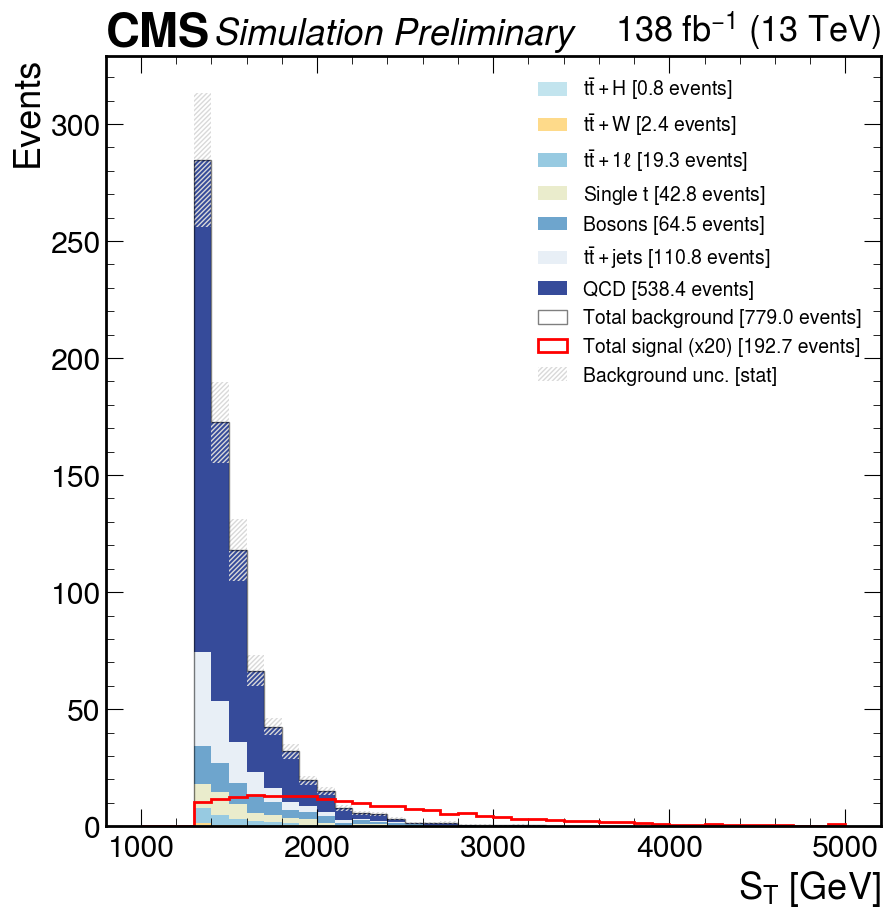

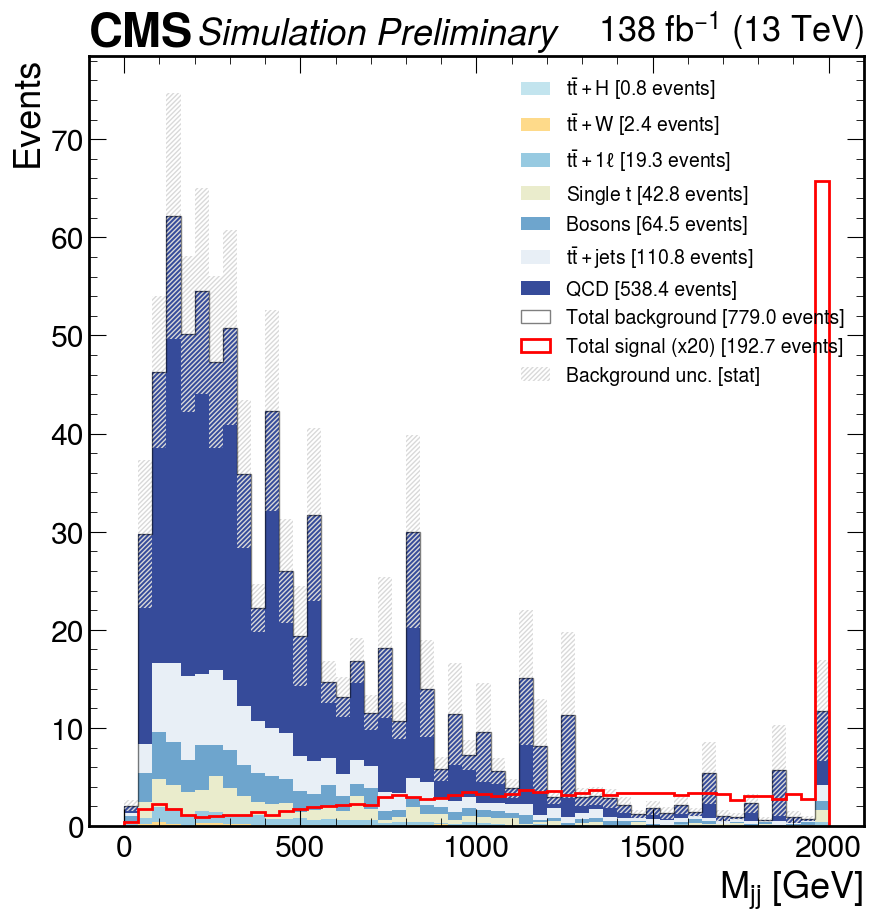

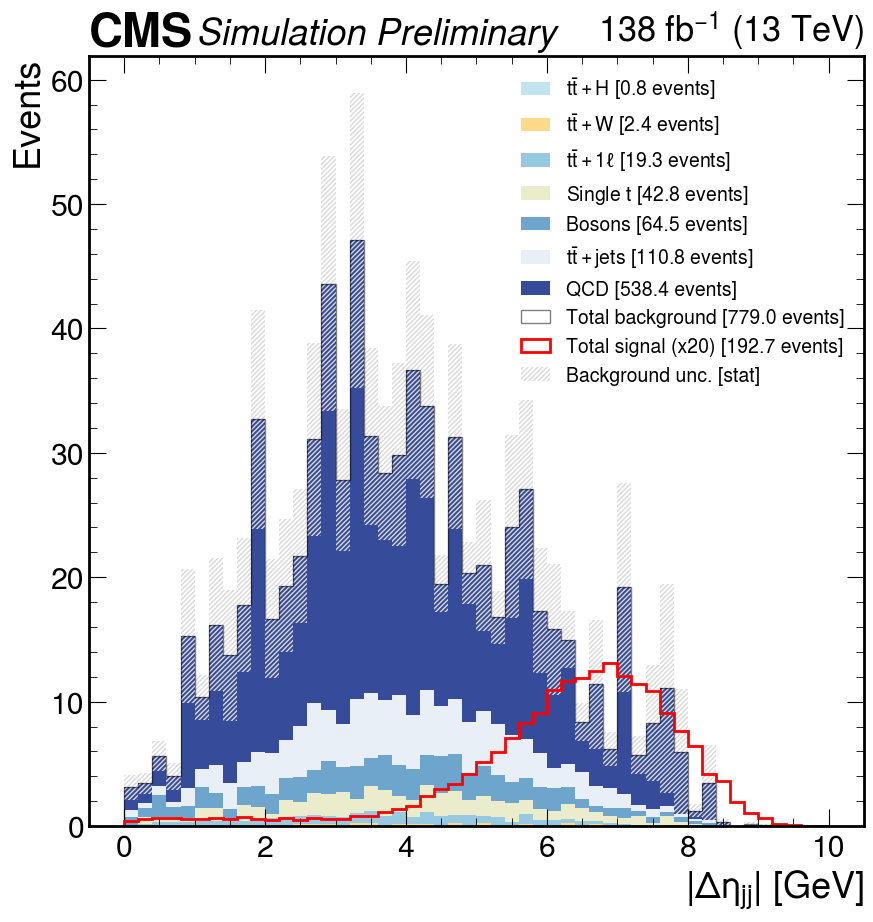

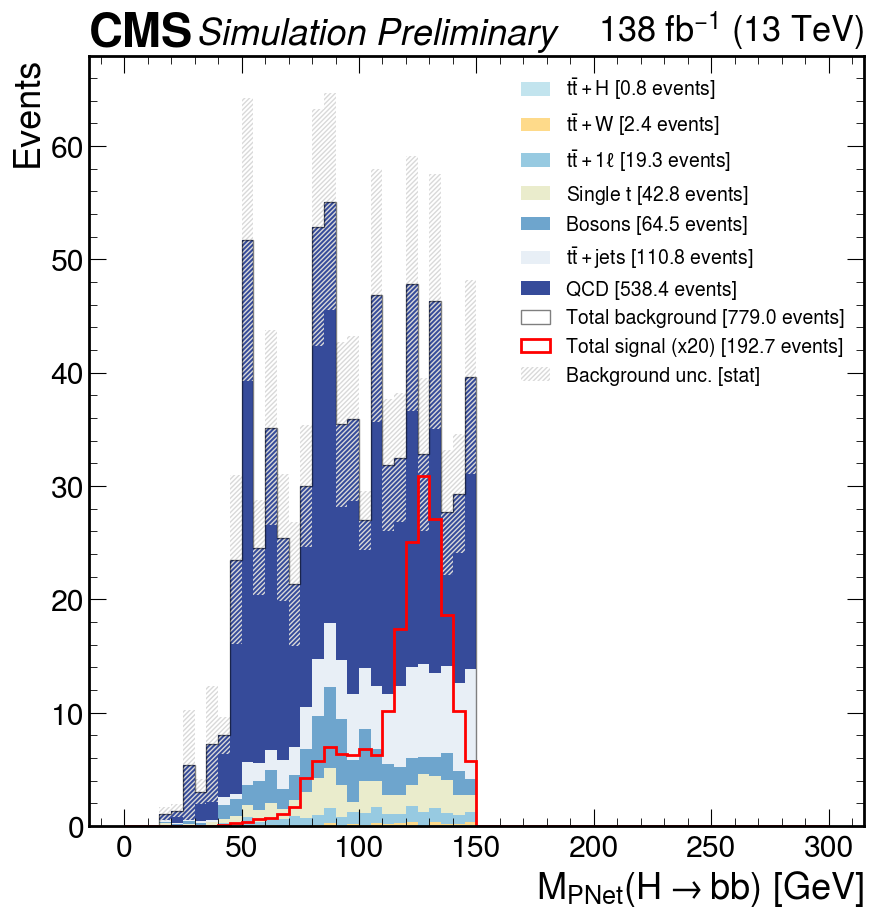

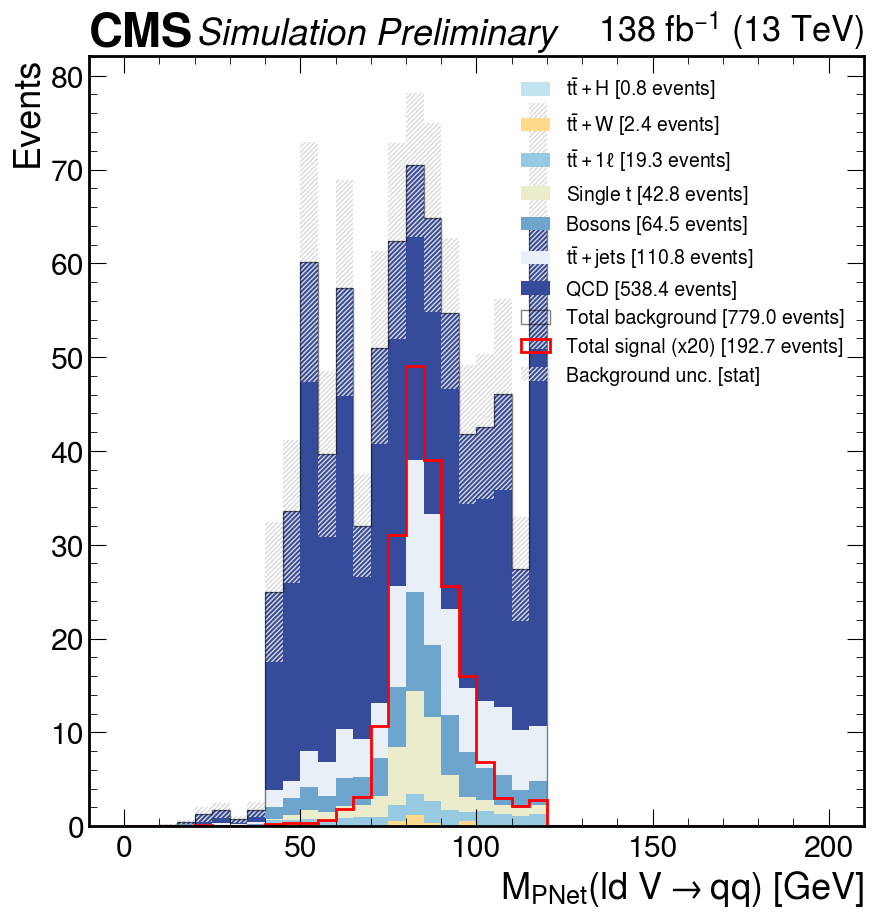

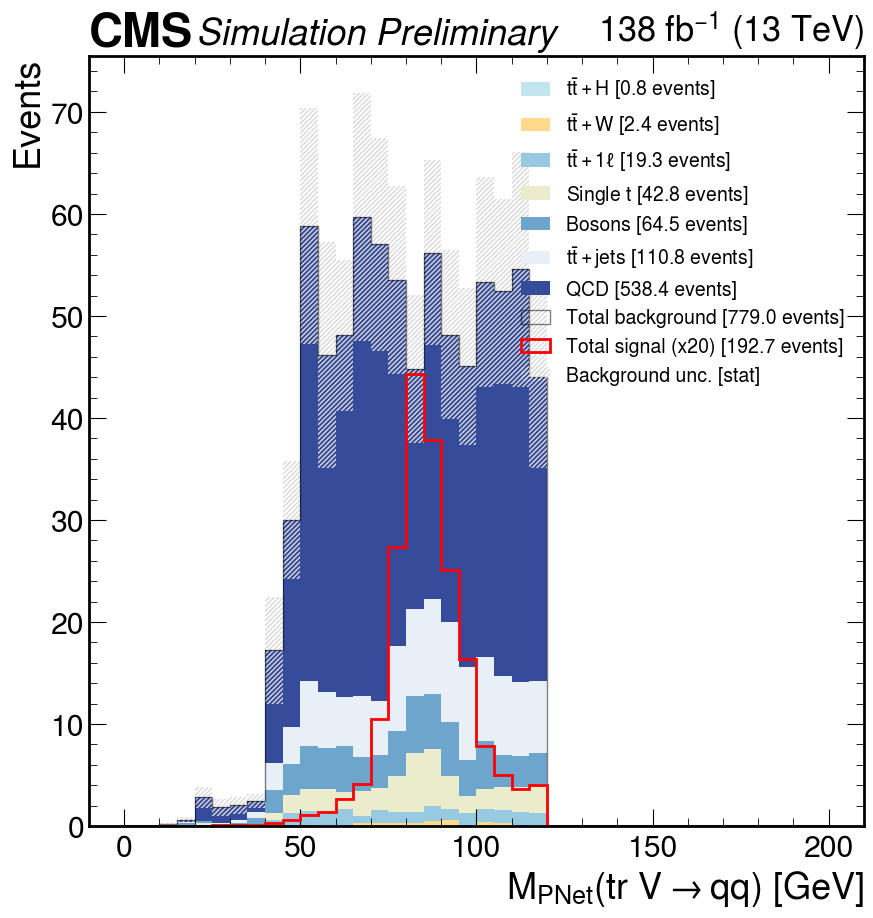

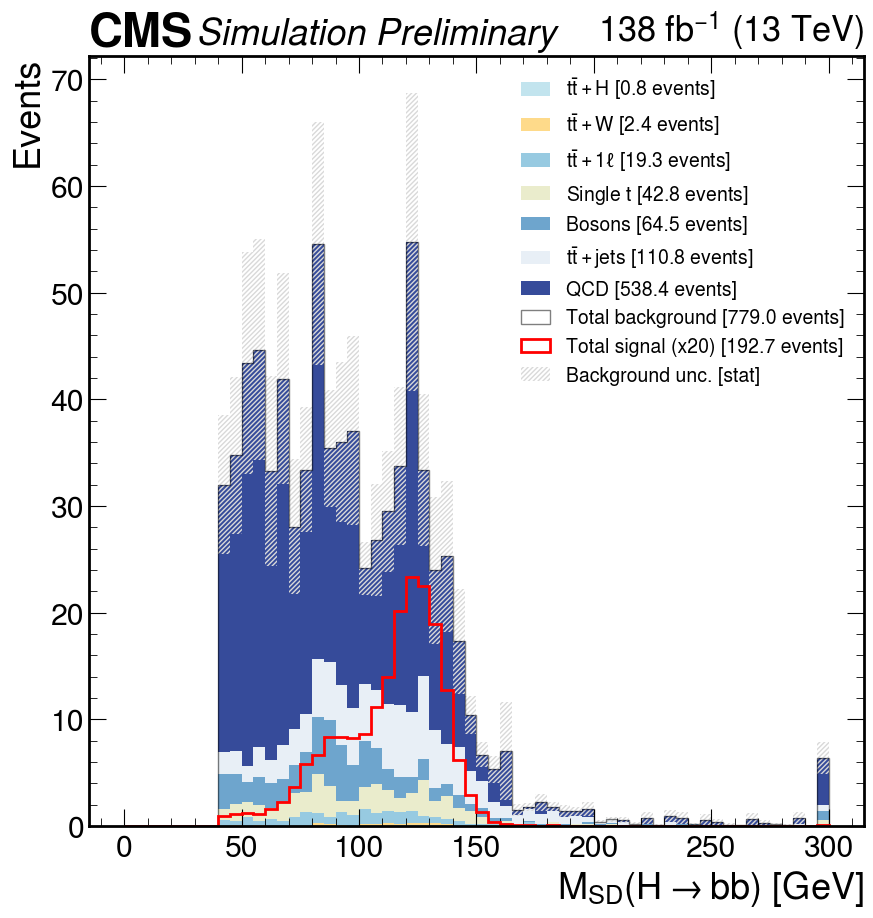

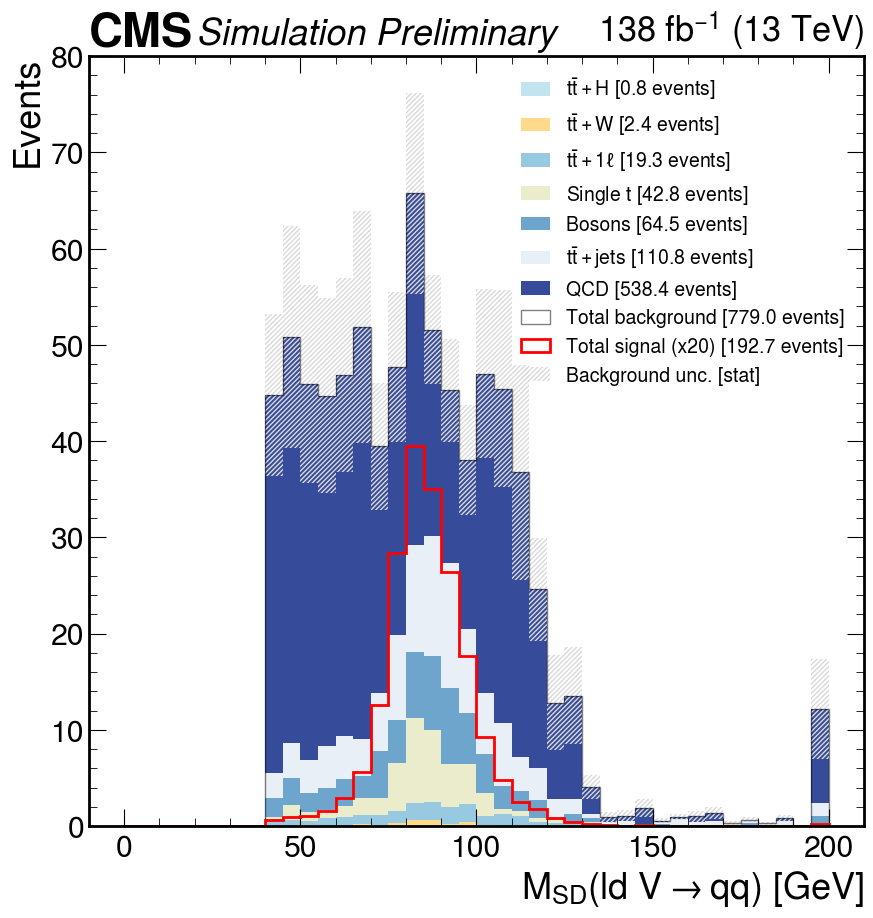

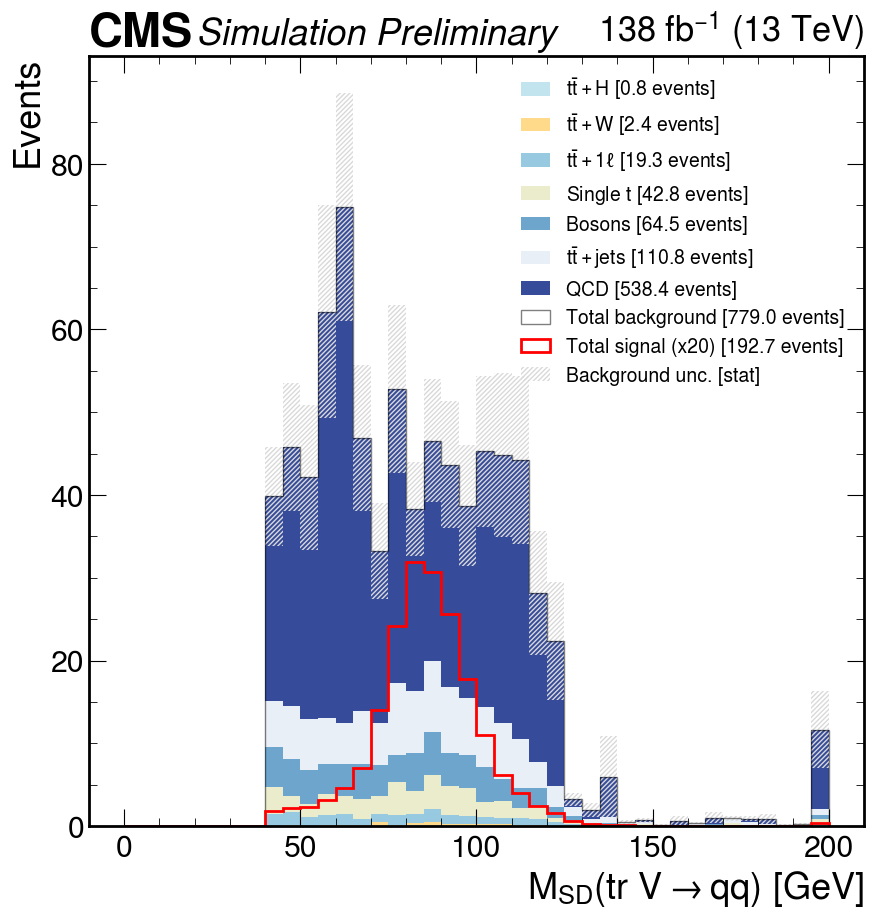

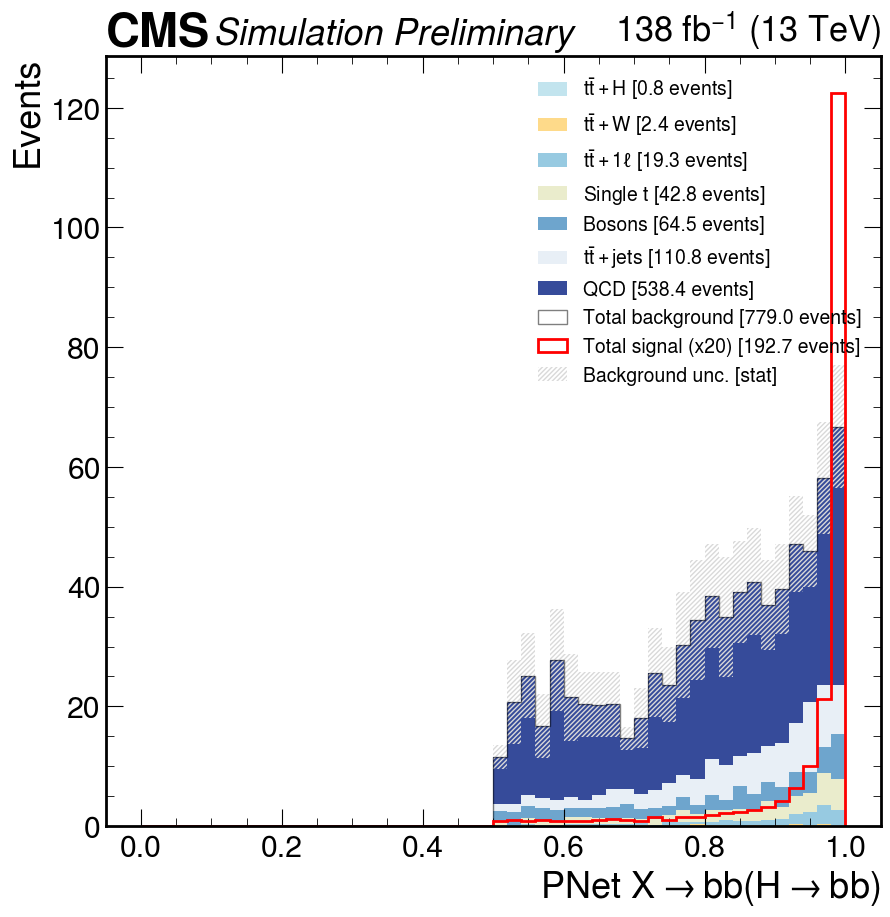

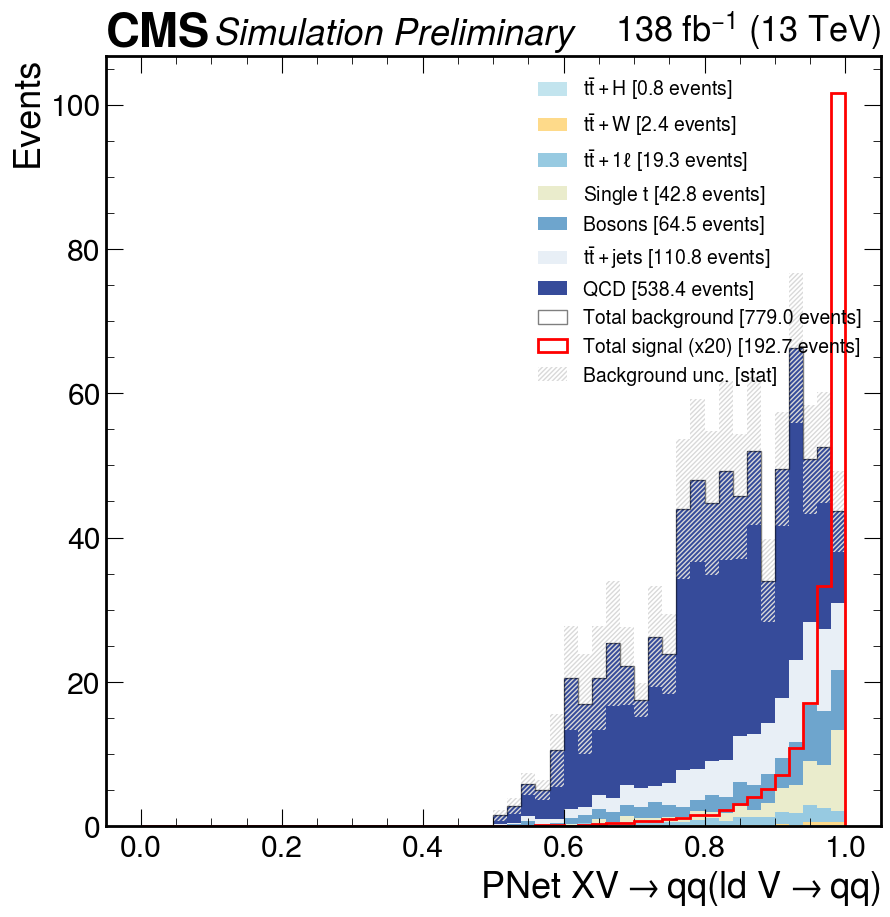

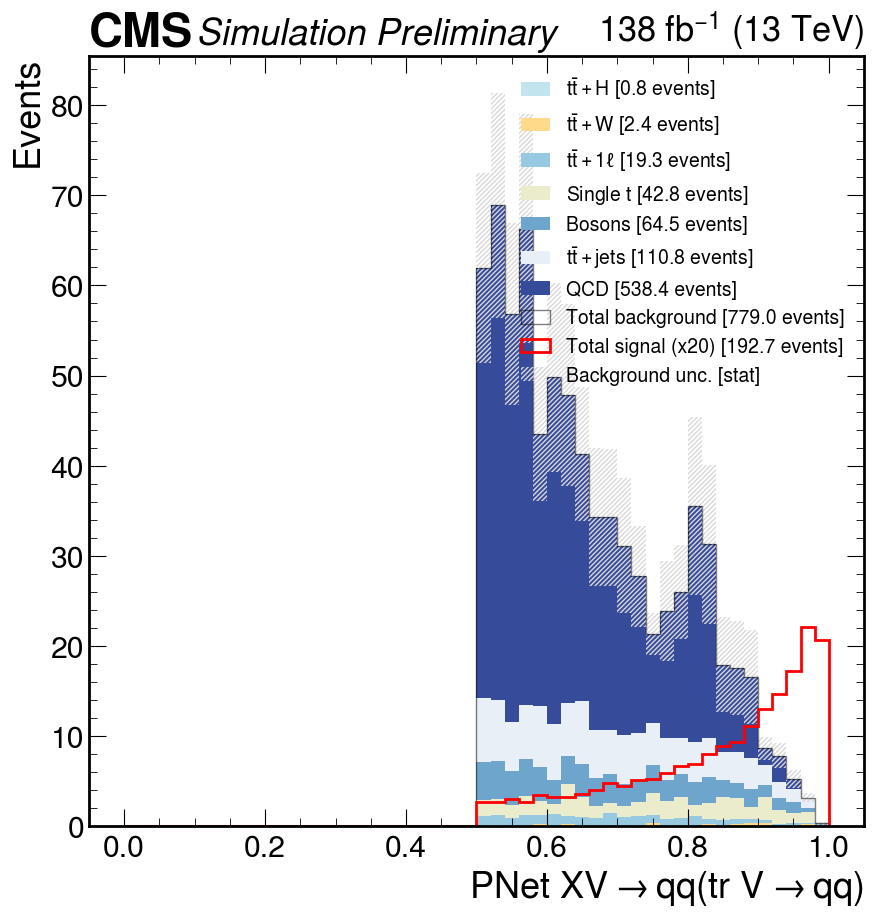

In [5]:
sel = "bdt_presel"

# Other
axes = vbsvvh.plot_sig_vs_bkg(
    "ST", np.linspace(1000, 5000, 41), 
    selection=sel,
    x_label="$S_T$ [GeV]",
    stacked=True,
    sig_scale=20
);

# VBS variables
axes = vbsvvh.plot_sig_vs_bkg(
    "M_jj", np.linspace(0, 2000, 51), 
    selection=sel,
    x_label=r"$M_{jj}$ [GeV]",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 51), 
    selection=sel,
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$ [GeV]",
    stacked=True,
    sig_scale=20
);

# Fat jet ParticleNet mass
axes = vbsvvh.plot_sig_vs_bkg(
    "hbbfatjet_mass", np.linspace(0, 300, 61), 
    selection=sel,
    x_label=r"$M_{PNet}(H\rightarrow bb)$ [GeV]",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "ld_vqqfatjet_mass", np.linspace(0, 200, 41), 
    selection=sel,
    x_label=r"$M_{PNet}($ld $V\rightarrow qq)$ [GeV]",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "tr_vqqfatjet_mass", np.linspace(0, 200, 41), 
    selection=sel,
    x_label=r"$M_{PNet}($tr $V\rightarrow qq)$ [GeV]",
    stacked=True,
    sig_scale=20
);

# Fat jet MSD
axes = vbsvvh.plot_sig_vs_bkg(
    "hbbfatjet_msoftdrop", np.linspace(0, 300, 61), 
    selection=sel,
    x_label=r"$M_{SD}(H\rightarrow bb)$ [GeV]",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "ld_vqqfatjet_msoftdrop", np.linspace(0, 200, 41), 
    selection=sel,
    x_label=r"$M_{SD}($ld $V\rightarrow qq)$ [GeV]",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "tr_vqqfatjet_msoftdrop", np.linspace(0, 200, 41), 
    selection=sel,
    x_label=r"$M_{SD}($tr $V\rightarrow qq)$ [GeV]",
    stacked=True,
    sig_scale=20
);

# Fat jet ParticleNet score
axes = vbsvvh.plot_sig_vs_bkg(
    "hbbfatjet_score", np.linspace(0, 1, 51), 
    selection=sel,
    x_label=r"PNet $X\rightarrow bb(H\rightarrow bb)$",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "ld_vqqfatjet_score", np.linspace(0, 1, 51), 
    selection=sel,
    x_label=r"PNet $XV\rightarrow qq($ld $V\rightarrow qq)$",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "tr_vqqfatjet_score", np.linspace(0, 1, 51), 
    selection=sel,
    x_label=r"PNet $XV\rightarrow qq($tr $V\rightarrow qq)$",
    stacked=True,
    sig_scale=20
);

Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/ST_sig_vs_bkg_stacked_bdt_presel_and_not_in_narrow_hwindow.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/M_jj_sig_vs_bkg_stacked_bdt_presel_and_not_in_narrow_hwindow.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/deta_jj_sig_vs_bkg_stacked_bdt_presel_and_not_in_narrow_hwindow.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/hbbfatjet_mass_sig_vs_bkg_stacked_bdt_presel_and_not_in_narrow_hwindow.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/ld_vqqfatjet_mass_sig_vs_bkg_stacked_bdt_presel_and_not_in_narrow_hwindow.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/tr_vqqfatjet_mass_sig_vs_bkg_stacked_bdt_presel_and_not_in_narrow_hwindow.pdf
Wrote plot to /home/users/jguiang/public_html/vbsvvhjets_plots/main/opt/hbbfatjet_msoftdrop_sig_vs_bkg_stacked_bdt_presel_and_not_in_narrow_h

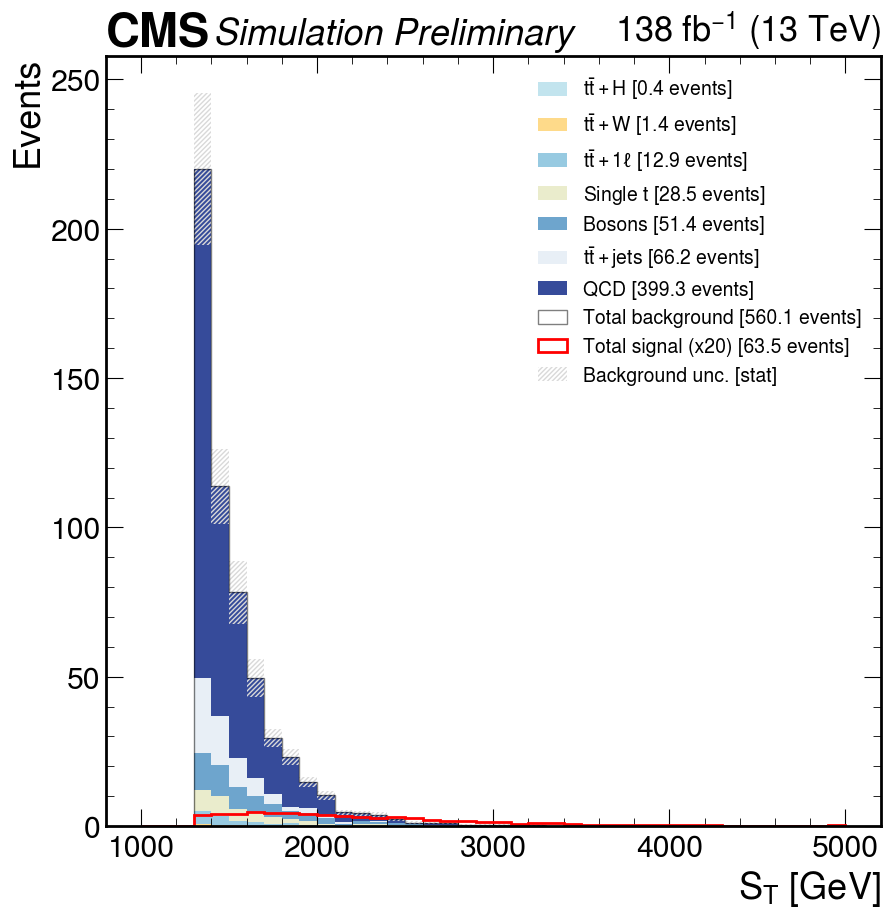

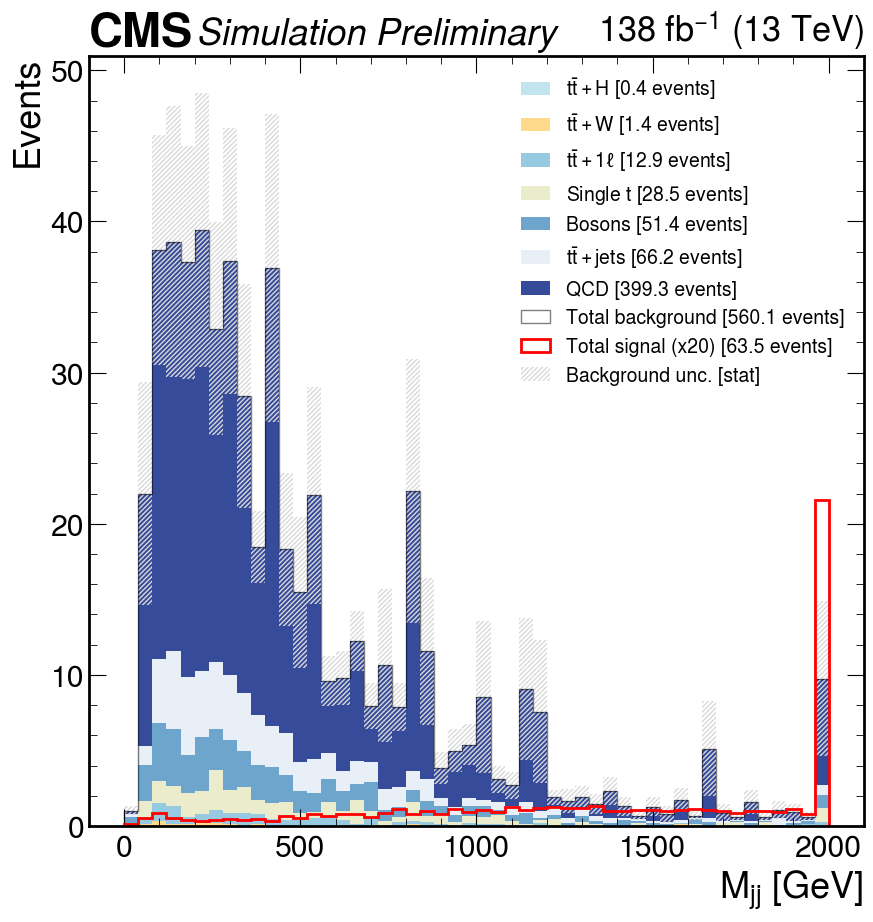

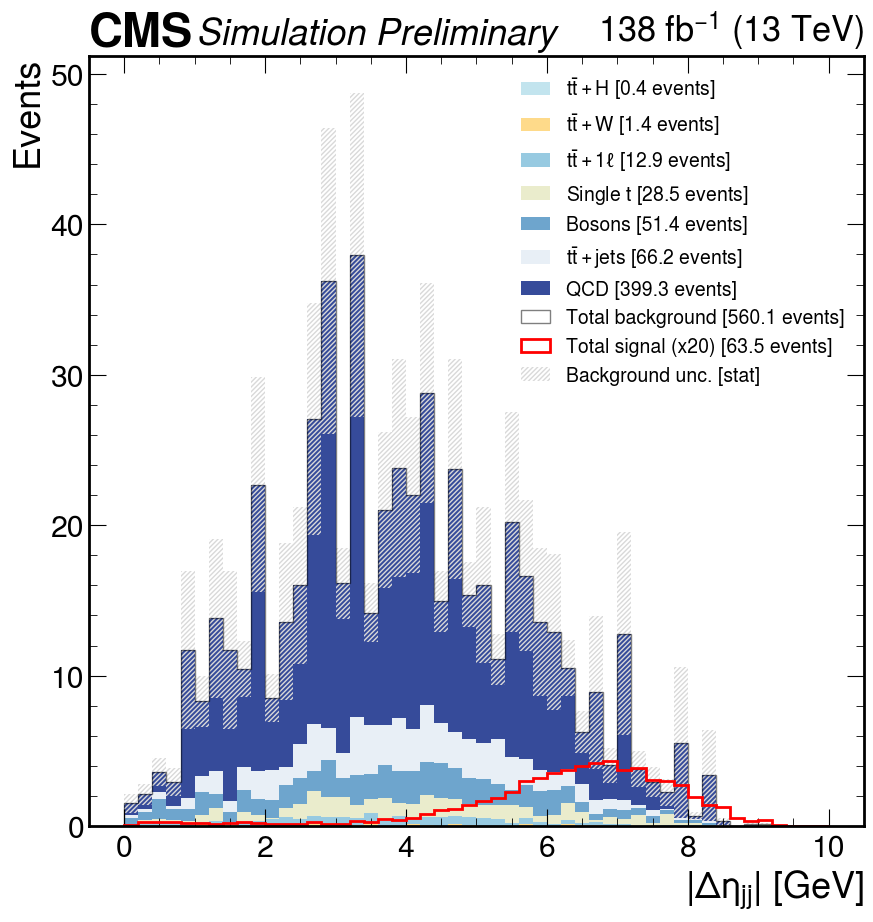

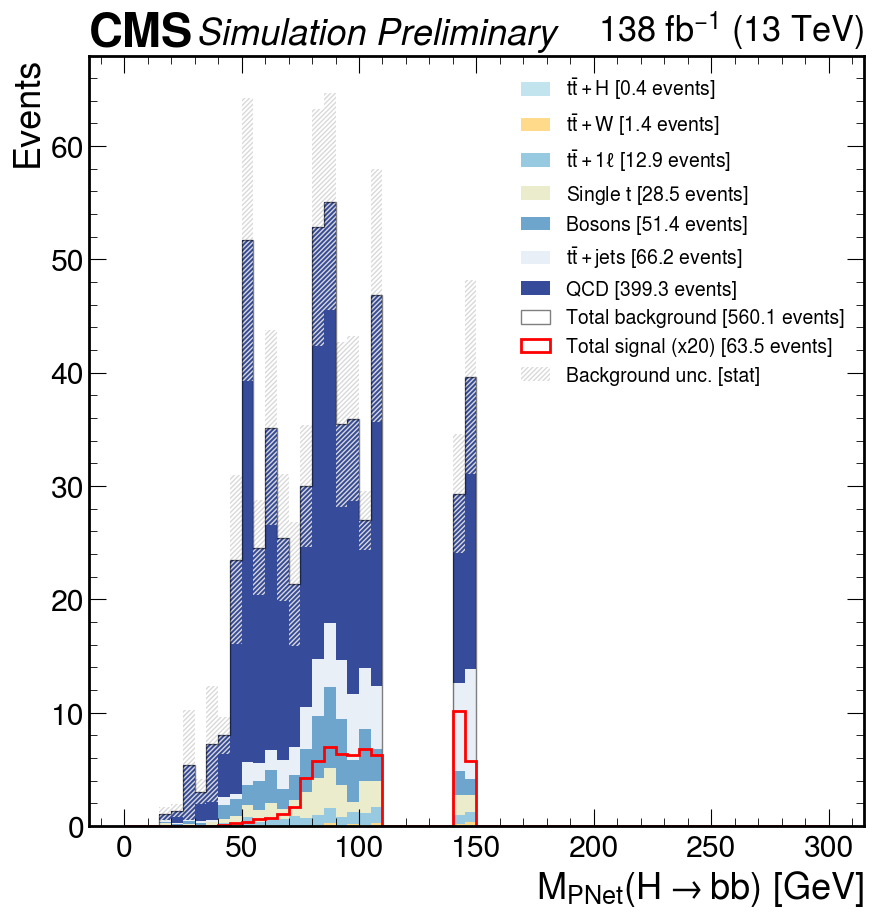

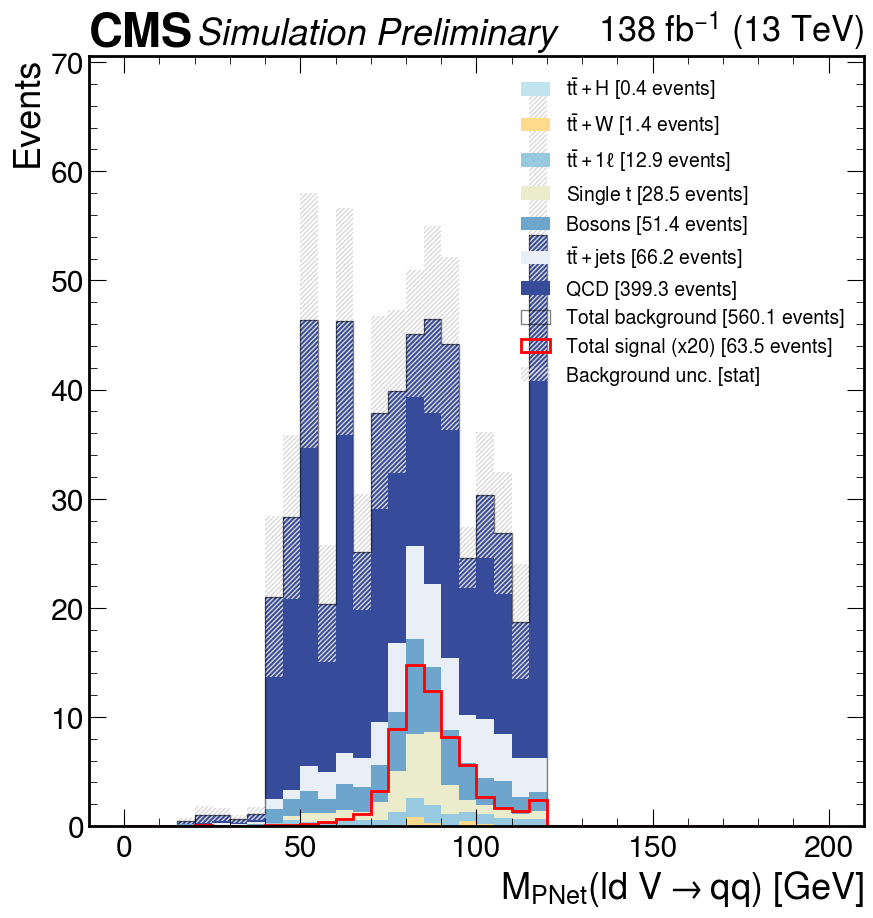

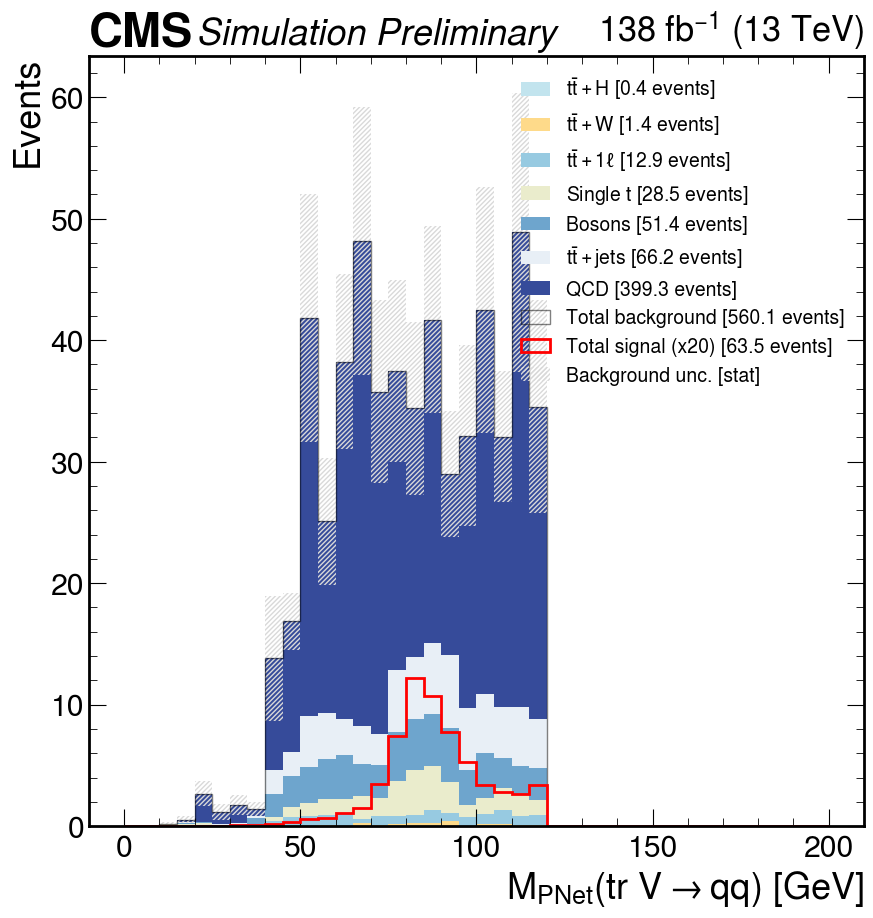

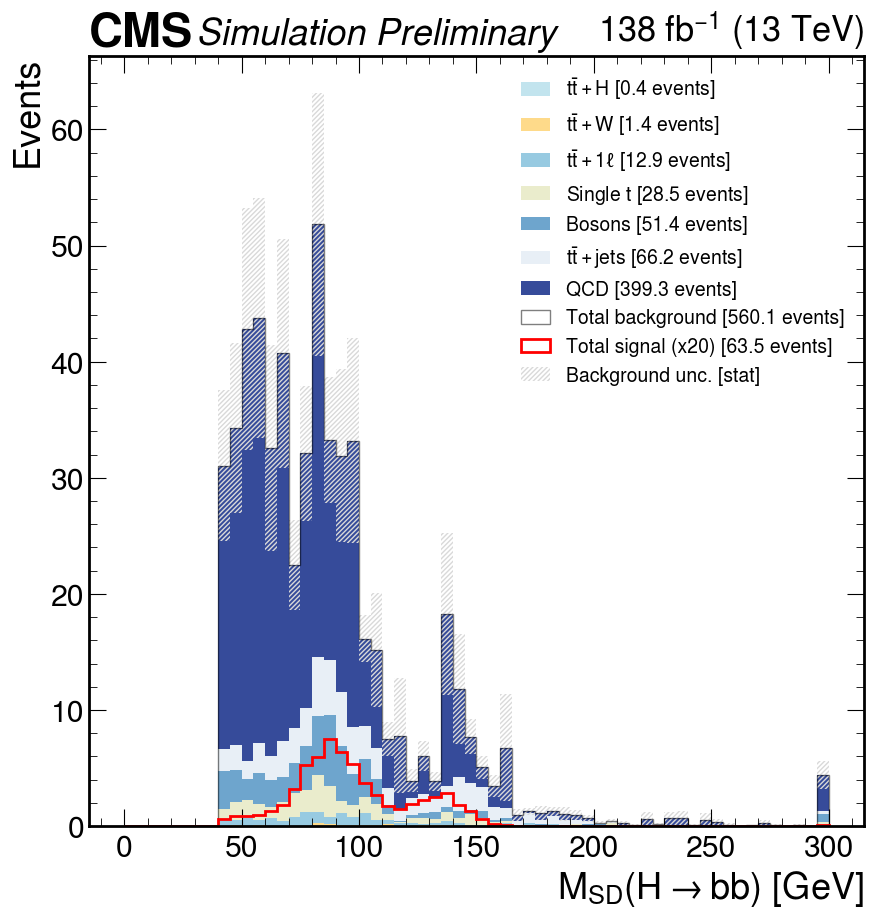

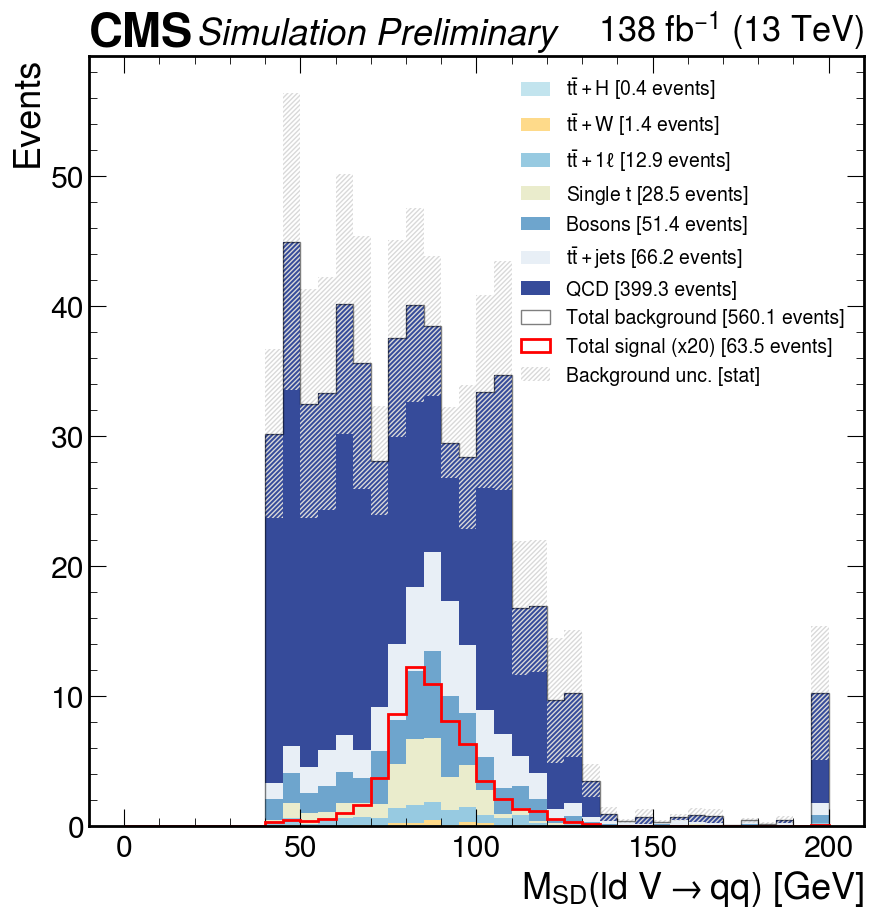

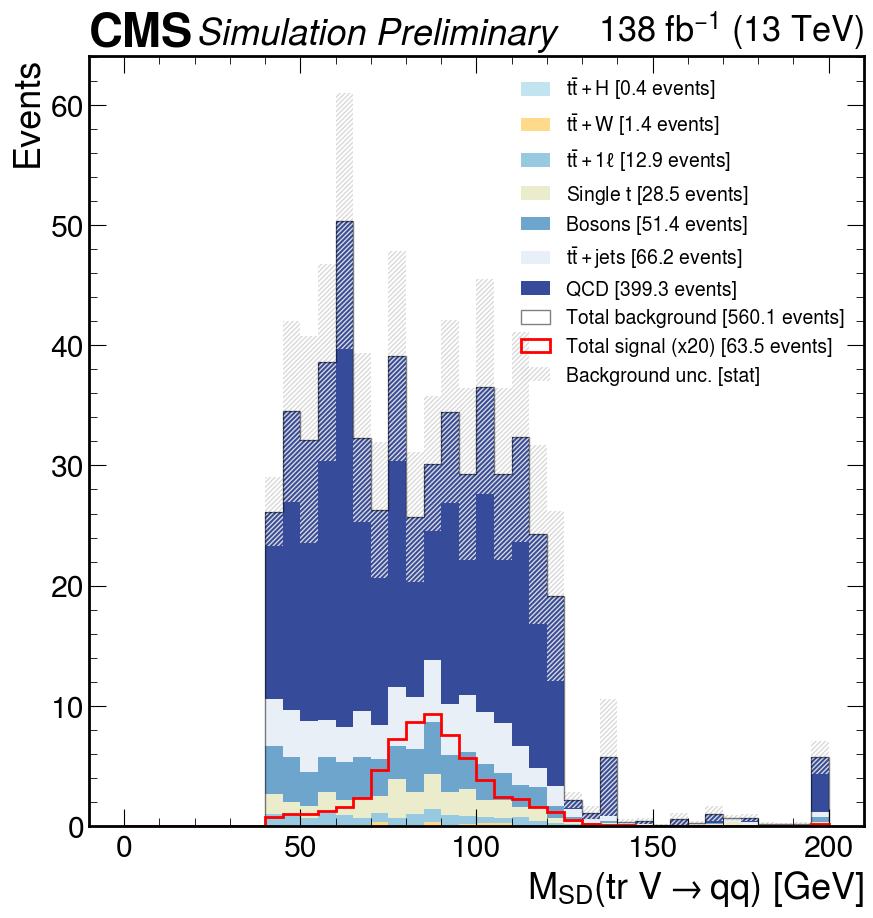

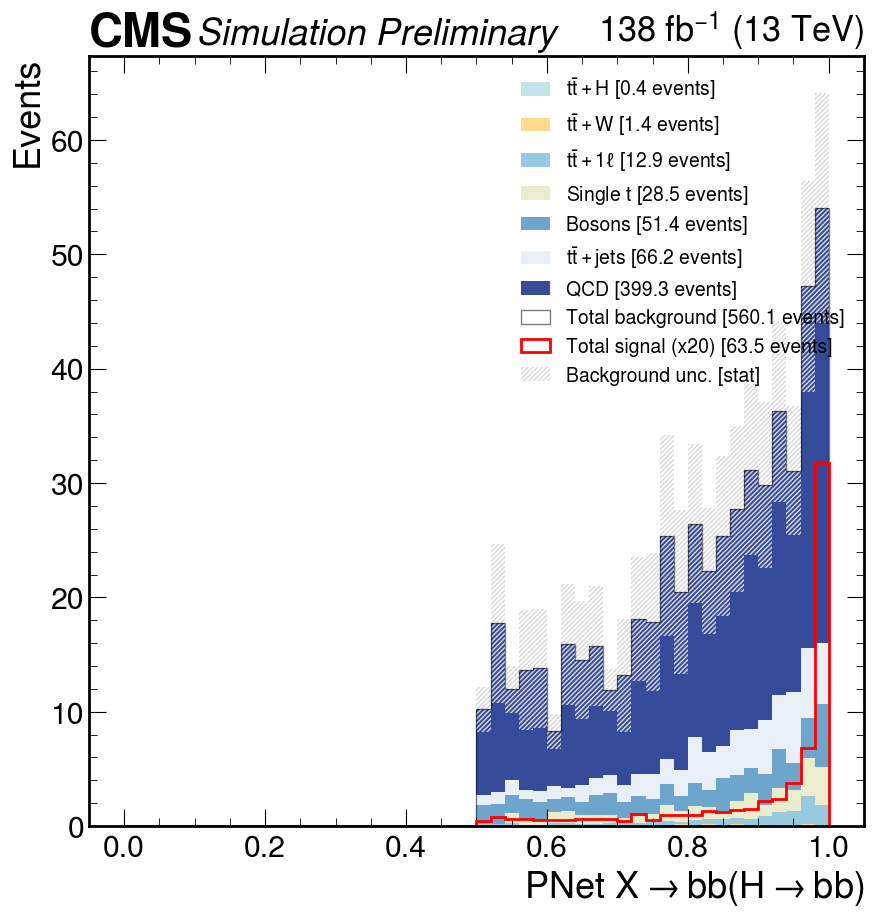

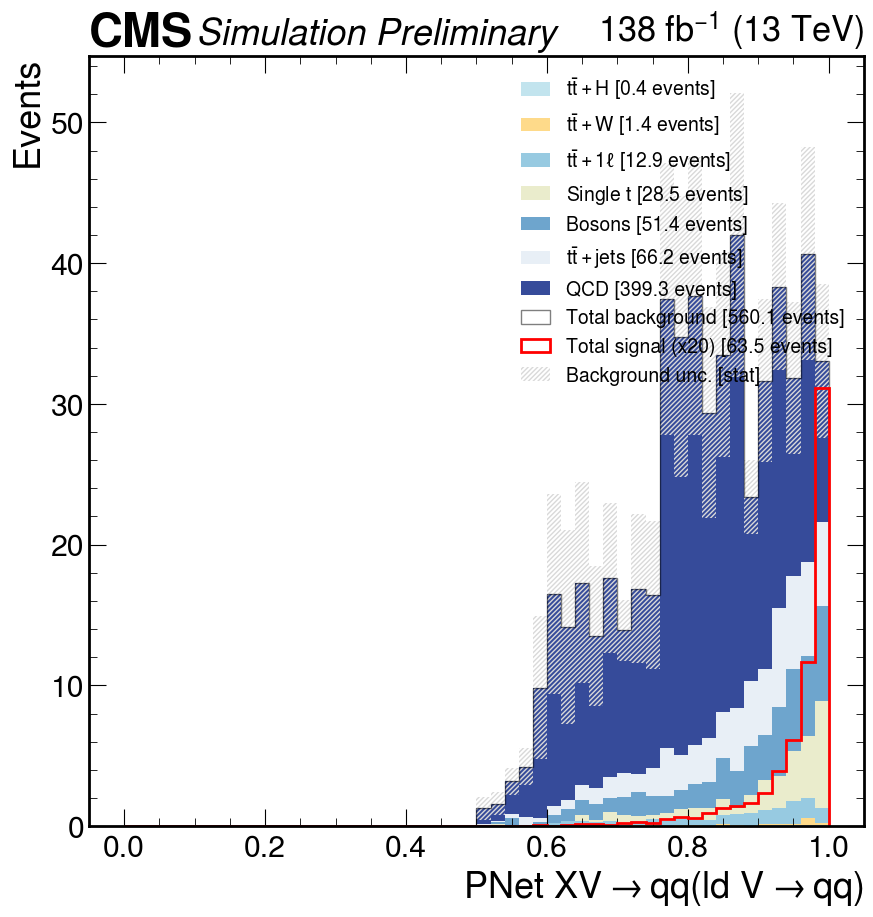

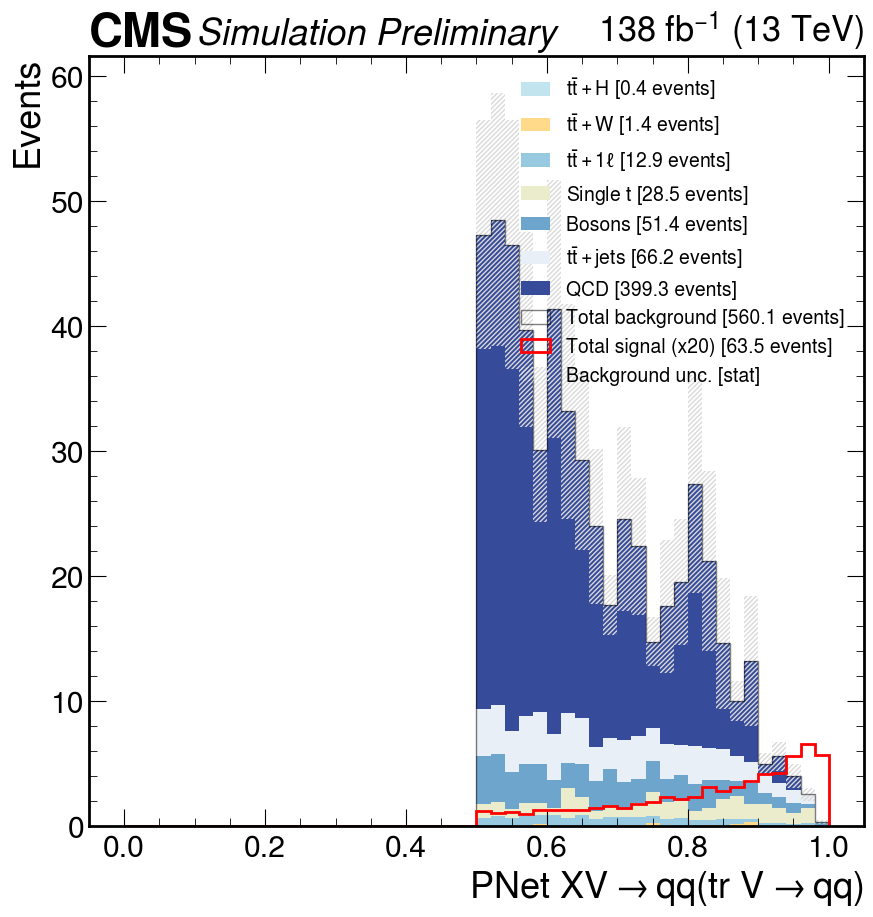

In [6]:
sel = "bdt_presel and not in_narrow_hwindow"

# Other
axes = vbsvvh.plot_sig_vs_bkg(
    "ST", np.linspace(1000, 5000, 41), 
    selection=sel,
    x_label="$S_T$ [GeV]",
    stacked=True,
    sig_scale=20
);

# VBS variables
axes = vbsvvh.plot_sig_vs_bkg(
    "M_jj", np.linspace(0, 2000, 51), 
    selection=sel,
    x_label=r"$M_{jj}$ [GeV]",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 51), 
    selection=sel,
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$ [GeV]",
    stacked=True,
    sig_scale=20
);

# Fat jet ParticleNet mass
axes = vbsvvh.plot_sig_vs_bkg(
    "hbbfatjet_mass", np.linspace(0, 300, 61), 
    selection=sel,
    x_label=r"$M_{PNet}(H\rightarrow bb)$ [GeV]",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "ld_vqqfatjet_mass", np.linspace(0, 200, 41), 
    selection=sel,
    x_label=r"$M_{PNet}($ld $V\rightarrow qq)$ [GeV]",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "tr_vqqfatjet_mass", np.linspace(0, 200, 41), 
    selection=sel,
    x_label=r"$M_{PNet}($tr $V\rightarrow qq)$ [GeV]",
    stacked=True,
    sig_scale=20
);

# Fat jet MSD
axes = vbsvvh.plot_sig_vs_bkg(
    "hbbfatjet_msoftdrop", np.linspace(0, 300, 61), 
    selection=sel,
    x_label=r"$M_{SD}(H\rightarrow bb)$ [GeV]",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "ld_vqqfatjet_msoftdrop", np.linspace(0, 200, 41), 
    selection=sel,
    x_label=r"$M_{SD}($ld $V\rightarrow qq)$ [GeV]",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "tr_vqqfatjet_msoftdrop", np.linspace(0, 200, 41), 
    selection=sel,
    x_label=r"$M_{SD}($tr $V\rightarrow qq)$ [GeV]",
    stacked=True,
    sig_scale=20
);

# Fat jet ParticleNet score
axes = vbsvvh.plot_sig_vs_bkg(
    "hbbfatjet_score", np.linspace(0, 1, 51), 
    selection=sel,
    x_label=r"PNet $X\rightarrow bb(H\rightarrow bb)$",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "ld_vqqfatjet_score", np.linspace(0, 1, 51), 
    selection=sel,
    x_label=r"PNet $XV\rightarrow qq($ld $V\rightarrow qq)$",
    stacked=True,
    sig_scale=20
);
axes = vbsvvh.plot_sig_vs_bkg(
    "tr_vqqfatjet_score", np.linspace(0, 1, 51), 
    selection=sel,
    x_label=r"PNet $XV\rightarrow qq($tr $V\rightarrow qq)$",
    stacked=True,
    sig_scale=20
);